In [34]:
#%%#############
###paths#####
#############
import sys
import os

pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1] 
sys.path.append(modellingpath + '/lib')
#############

from numerical.cn_edgegrowth2_numba import cn_edgegrowth2 as cn_edgegrowth2_numba
from numerical.cn_edgegrowth2 import cn_edgegrowth2
from numerical.cn_nogrowth import cn_nogrowth
from numerical.cn_nogrowth_numba import cn_nogrowth_numba

from numerical.cn_plot import plot1D, surfpattern
from numerical.run_plot_1D import *
from pattern_classification.pattern_1D_classification import *
import pickle
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd


### Numerical params

In [35]:
#system parameters
circuit_n = 'turinghill'
variant=9
n_param_sets = 2000000


# #solver parameters
# L=30; dx =0.1; J = int(L/dx)
# T =1000; dt = 0.02; N = int(T/dt)


#solver parameters
L=50; dx =0.1; J = int(L/dx)
T =2000; dt = 0.02; N = int(T/dt)

boundaryCoeff=1;rate=L/T
suggesteddt = float(dx*dx*2)


print(f'suggested dt = {suggesteddt}, used dt = {dt}')

suggesteddt = float(dx*dx*2)
print(f'suggested dt = {suggesteddt}, used dt = {dt}')


suggested dt = 0.020000000000000004, used dt = 0.02
suggested dt = 0.020000000000000004, used dt = 0.02


### Model params

In [36]:

df= pickle.load( open(modellingpath + "/growth/out/analytical/turing/turing_df_%s_variant%r_%rparametersets.pkl"%(circuit_n,variant,n_param_sets), "rb"))




## Patterns computation

In [4]:

# #solver parameters
# L=30; dx =0.1; J = int(L/dx)
# T =1000; dt = 0.02; N = int(T/dt)

for parID in df.index[:2]:
    par_dict = par_dict = df.loc[parID].to_dict()


    #solver parameters
    L=50; dx =0.1; J = int(L/dx)
    T =2000; dt = 0.02; N = int(T/dt)

    boundaryCoeff=1;rate=L/T
    suggesteddt = float(dx*dx*2)


    U_final, U_record = simulate_plot_nogrowth(par_dict, L, J, T, N, circuit_n,tqdm_disable=True)
    pattern, converged, flat, regular = patternClassification(U_final, U_record)
    print(f'pattern:{pattern}, converged:{ converged}, flat:{ flat}, regular:{regular} ')
    print('-----------------------------------------')
    print('')

KeyboardInterrupt: 

In [37]:
def create_grids(L,J, T,N):

    record_every_x_hours = 10

    #storage variables
    reduced_t_grid = np.arange(0,T,record_every_x_hours) 


        #spatial variables
    dx = float(L)/float(J-1)
    x_grid = np.array([j*dx for j in range(J)])
    x_gridpoints = J/L
    
    #temporal variables
    dt = float(T)/float(N-1)
    t_grid = np.array([n*dt for n in range(N)])
    t_gridpoints =  N/T 
    return  x_grid, reduced_t_grid

x_grid, reduced_t_grid = create_grids(L,J,T,N)

In [38]:

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)+1e-8)

def countPeaks(U, showPlot1D=True):
    peaks = [0,0]
    peaks[0], _ = find_peaks(U[0], prominence=0.1)
    peaks[1], _ = find_peaks(U[1], prominence=0.1)
    if showPlot1D == True:
        plot1D(U,plotPeaks=True, peaks=peaks)

    return peaks

def patternClassification(U_final, U_record, normalize=True):
    #check if flat
    relRangeFlat = [(np.amax(U) - np.amin(U))/(np.amax(U)+1e-8) for U in U_final]
    if any(i<0.001 for i in relRangeFlat):
        flat=True
    else:
        flat=False

    #check if converged
    relRangeConverged=[0,0]
    for count,Ux_record in enumerate(U_record):
        relRangeConverged[count] = [(np.amax(x) - np.amin(x))/(np.amax(x)+1e-8) for x in np.transpose(Ux_record[-3:])]
    # if np.amax(relRangeConverged[0])>0.001 or np.amax(relRangeConverged[1])>0.001:
    # if np.amax(relRangeConverged[0])>0.01 or np.amax(relRangeConverged[1])>0.01:
    if np.amax(relRangeConverged[0])>0.1 or np.amax(relRangeConverged[1])>0.1:
        converged=False
    else:
        converged=True

    #check if regular
    U_final_norm = [NormalizeData(U) for U in U_final]
    peaks = countPeaks(U_final_norm, showPlot1D=False)

    #calculate distance between peaks in peak0
    std=[0,0]
    for count,singleUpeak in enumerate(peaks):
        if len(singleUpeak)>2:
            peak_dist = [np.linalg.norm(singleUpeak[i]-singleUpeak[i+1]) for i in range(len(singleUpeak)-1)]
            peak_dist = peak_dist/np.sum(peak_dist)
            std[count] = np.std(peak_dist)
        else:
            std[count] = 1
    if std[0]<0.01 and std[1]<0.01:
        regular=True
    else:
        regular=False
        


    if flat==True and converged==True:
        pattern='Homogeneous'
    if flat==True and converged==False:
        pattern='Temporal Oscillator'
    if flat==False and converged==True and regular==True:
        pattern = 'Stationary regular pattern'
    if flat==False and converged==True and regular==False:
        pattern = 'Stationary irregular pattern'

    if flat==False and converged==False and regular==True:
        pattern = 'Non-Stationary regular pattern'
    if flat==False and converged==False and regular==False:
        pattern = 'Non-Stationary irregular pattern'
    # if var[0]>0.1 and var[1]>0.1:

    return pattern, converged, flat, regular

## No growth

104782.0


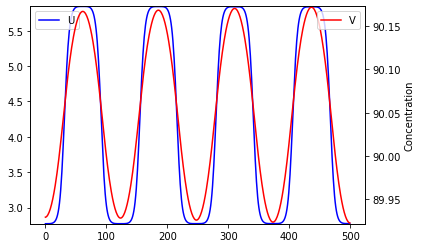

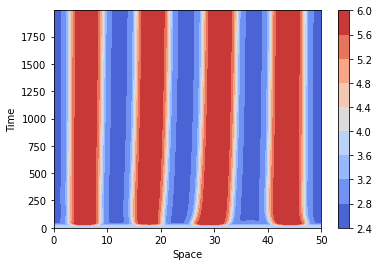

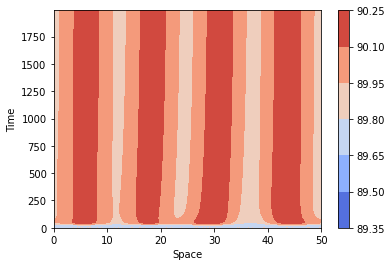

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1748606.0


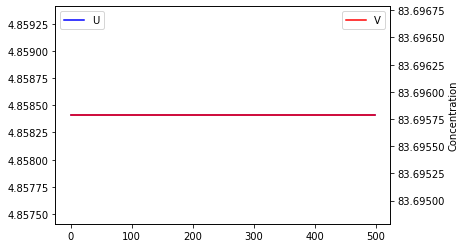

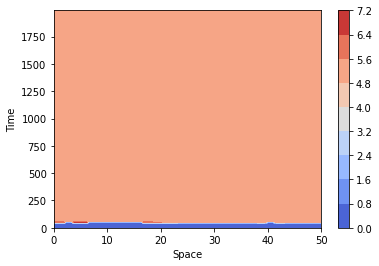

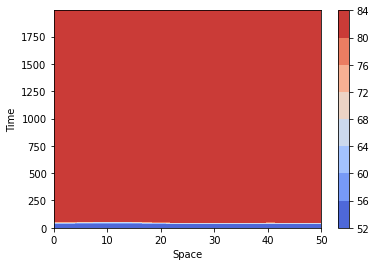

pattern:Homogeneous, converged:True, flat:True, regular:False 
-----------------------------------------

1471198.2


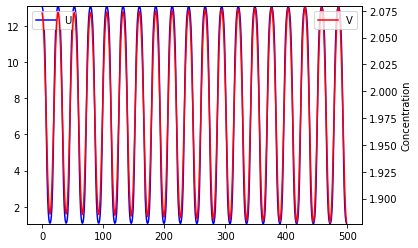

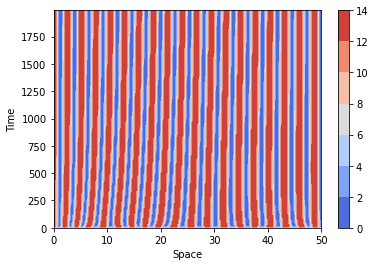

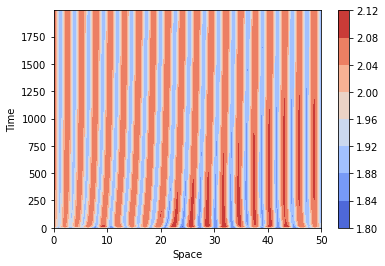

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

942691.1


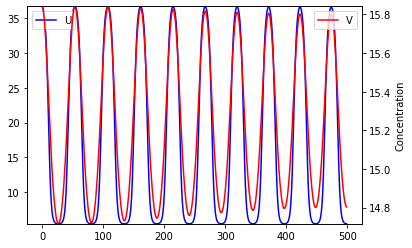

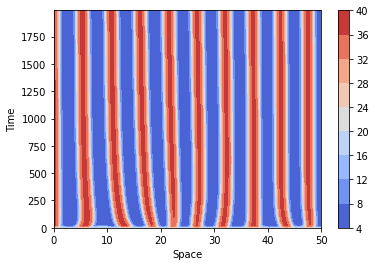

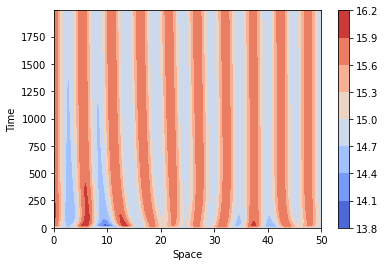

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

903128.0


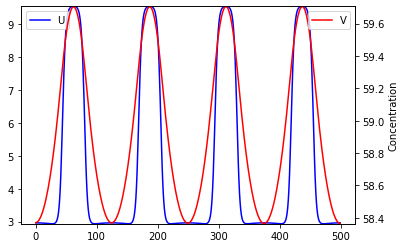

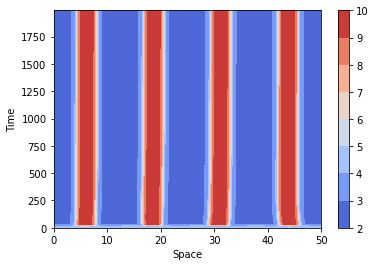

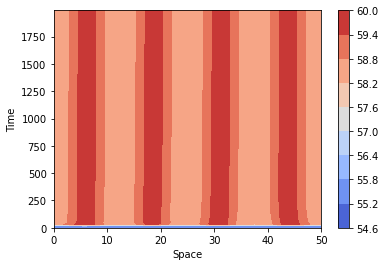

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1396843.0


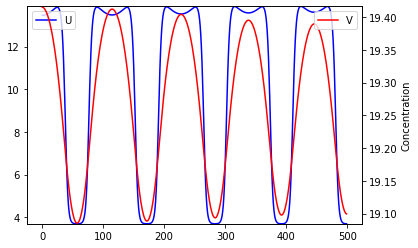

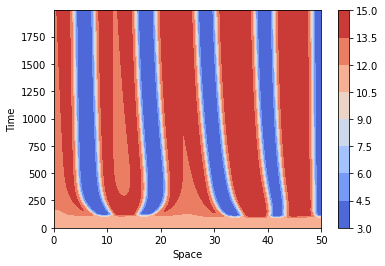

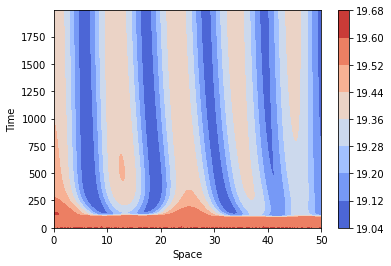

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1928281.0


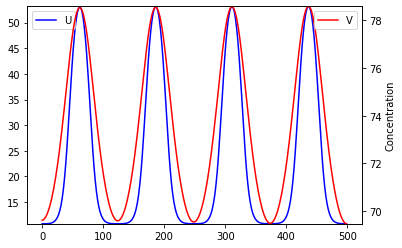

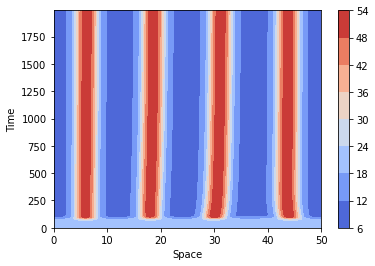

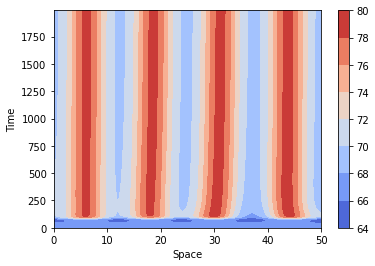

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

195855.1


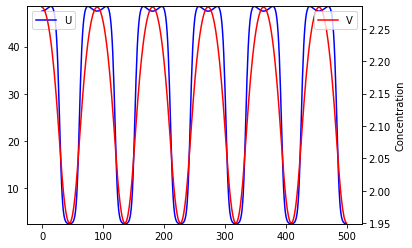

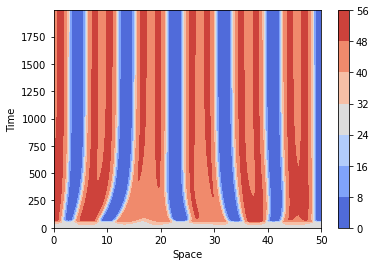

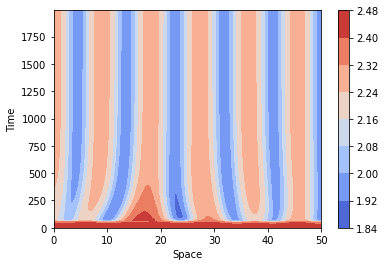

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1042553.0


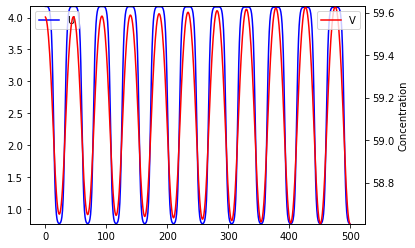

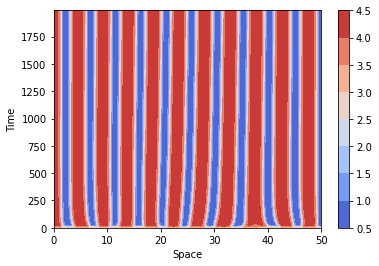

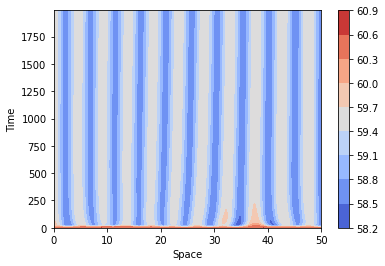

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1287827.0


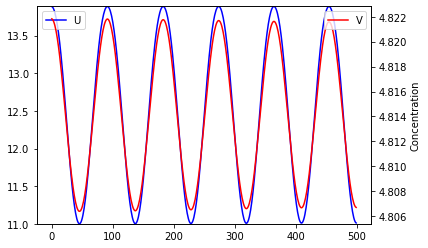

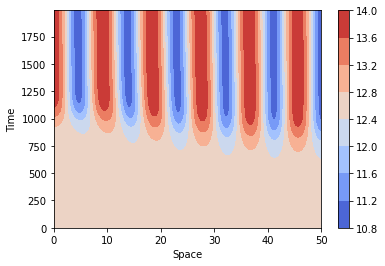

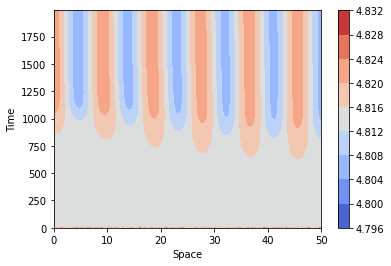

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1917168.0


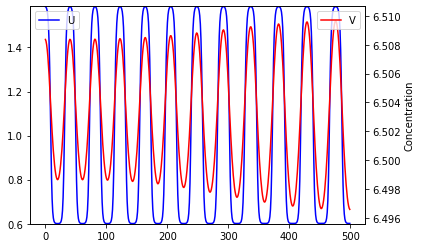

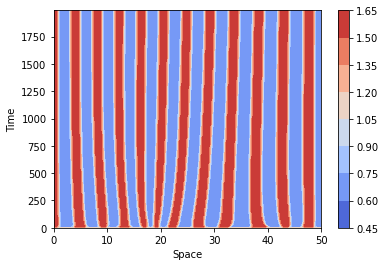

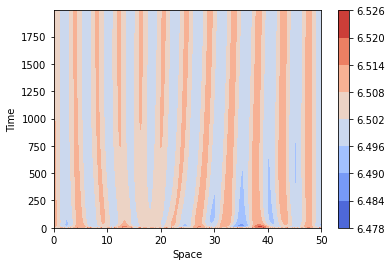

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

202243.0


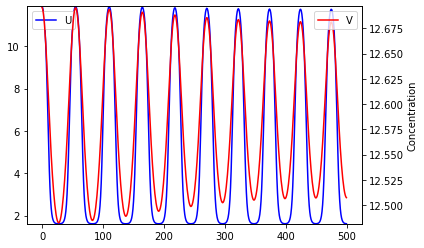

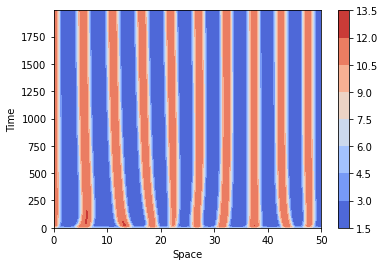

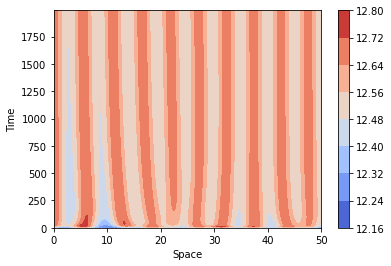

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

639624.0


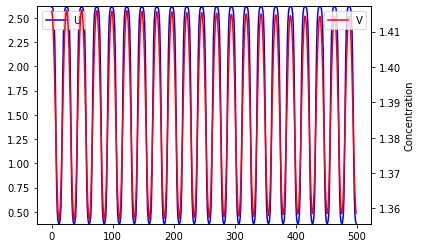

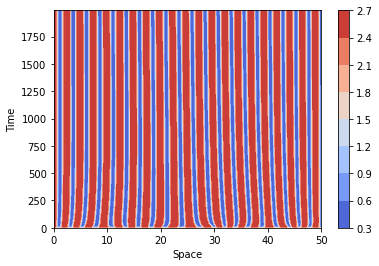

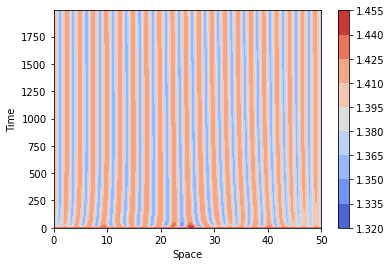

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

511906.0


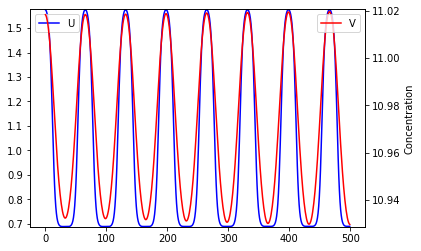

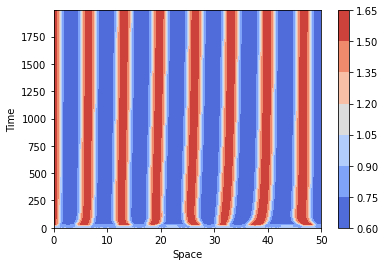

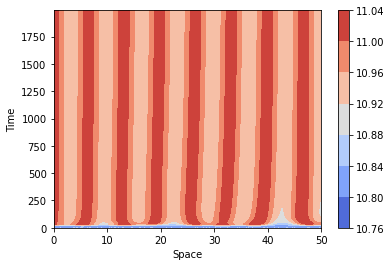

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

775319.1


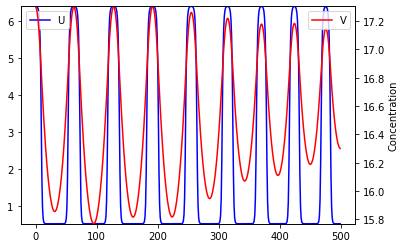

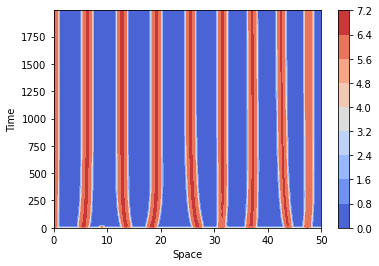

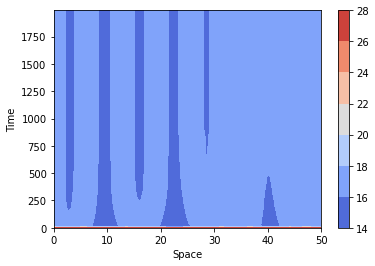

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

211773.0


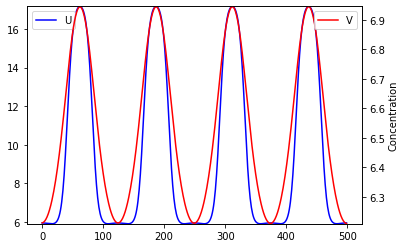

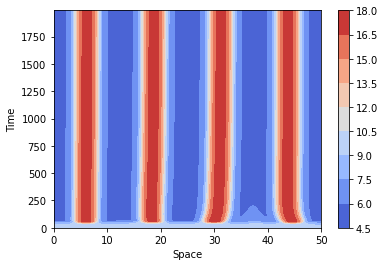

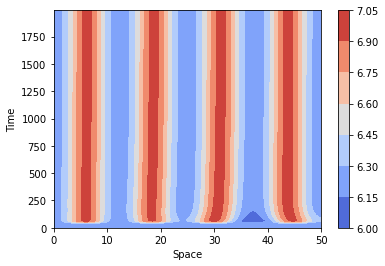

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

129165.0


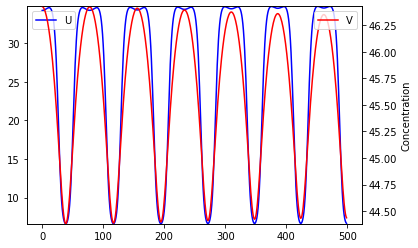

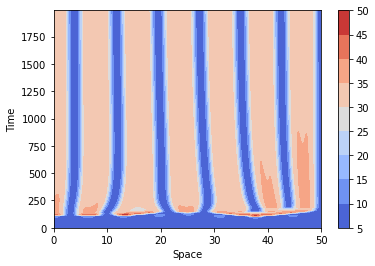

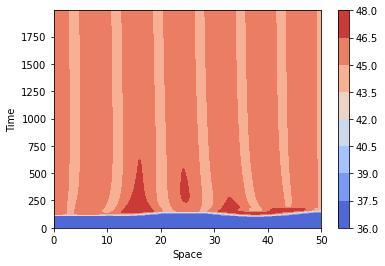

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

571384.0


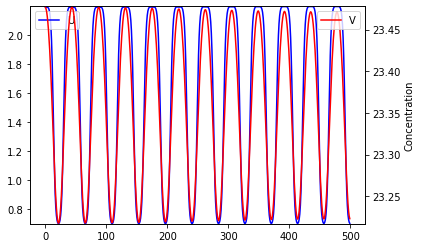

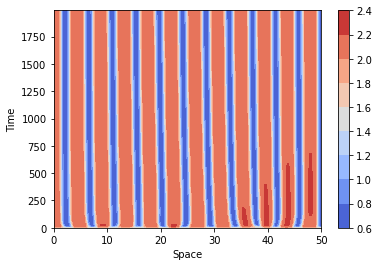

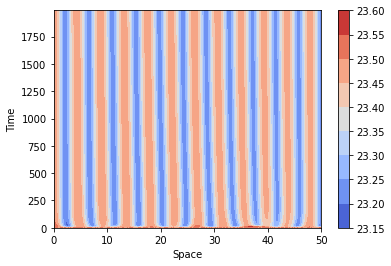

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1462422.0


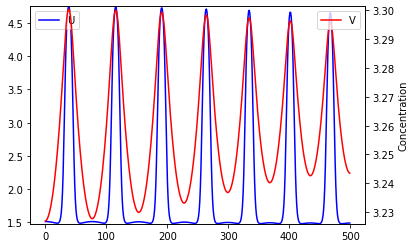

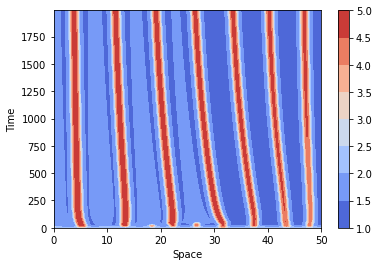

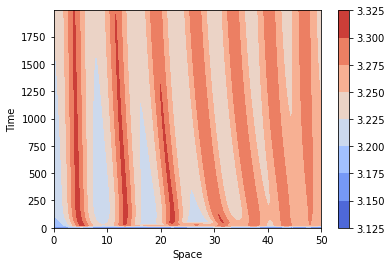

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

584464.0


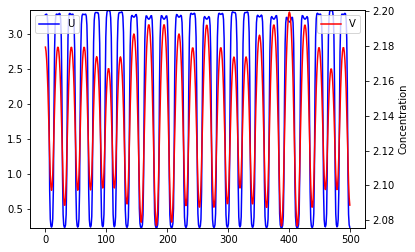

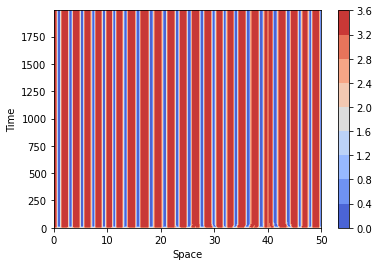

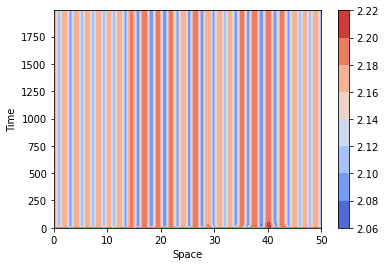

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1442645.0


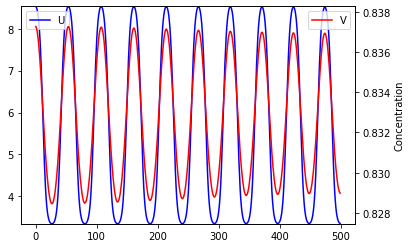

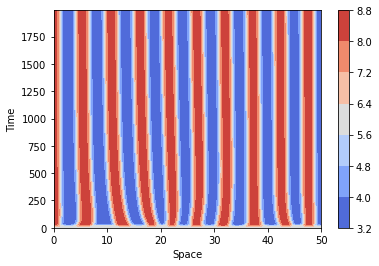

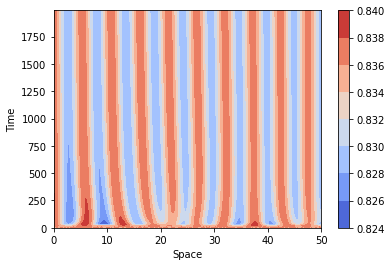

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

751715.0


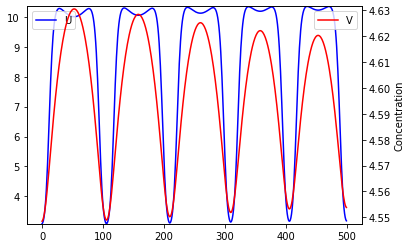

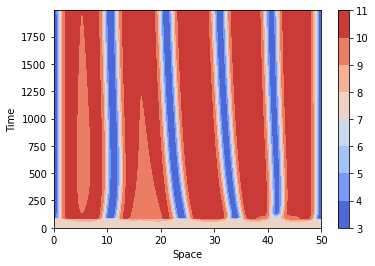

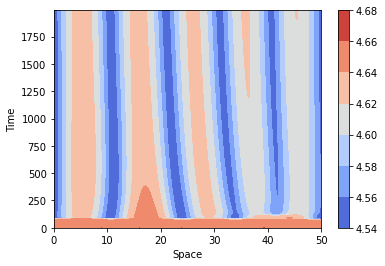

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

284887.0


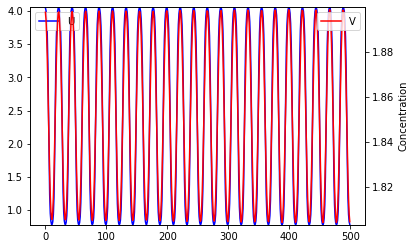

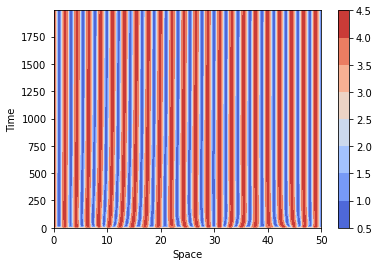

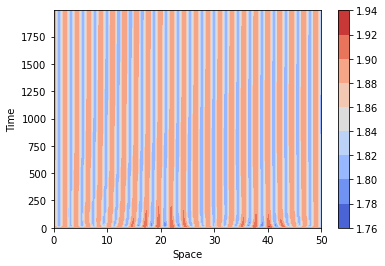

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1697541.0


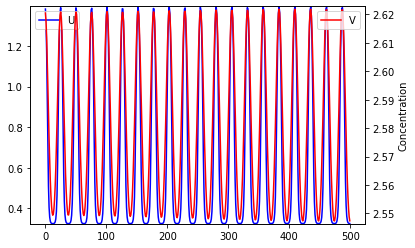

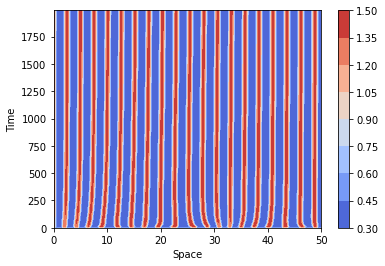

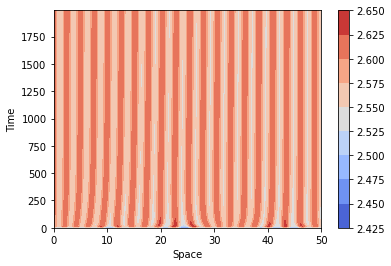

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

518029.0


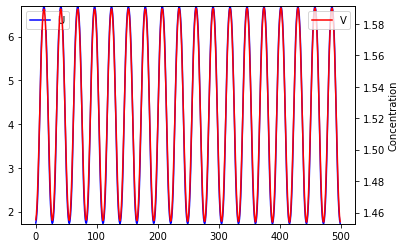

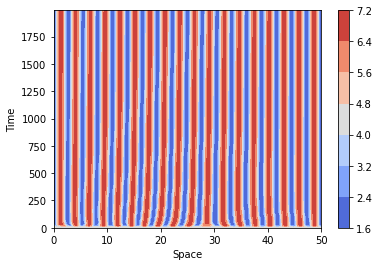

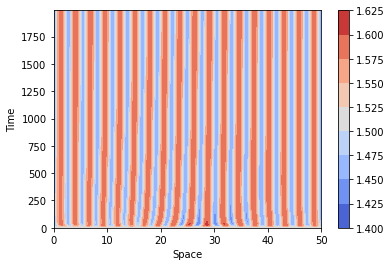

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1230834.1


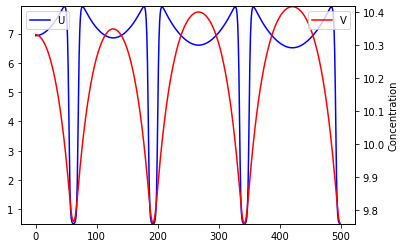

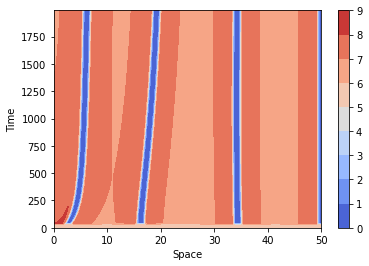

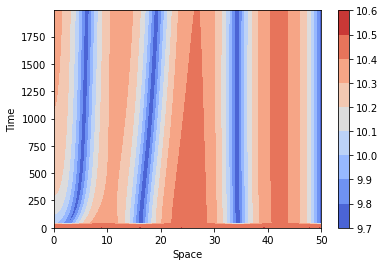

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

164798.0


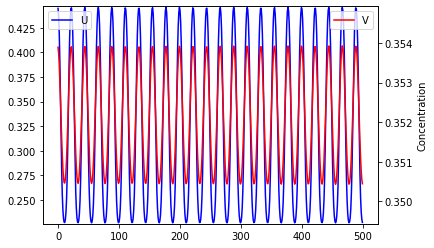

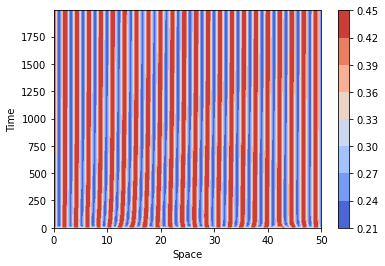

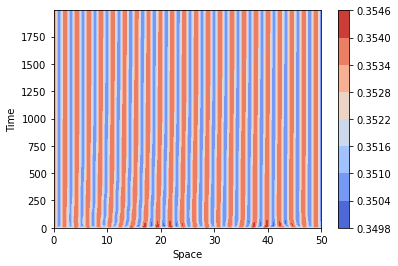

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1061542.0


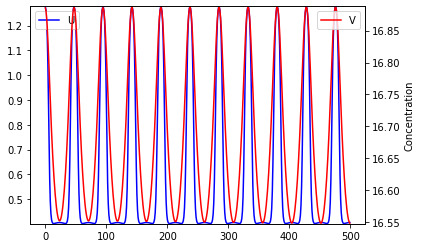

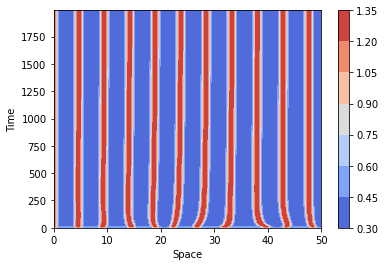

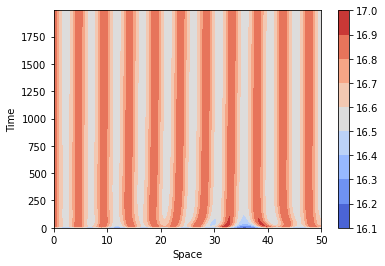

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1280327.0


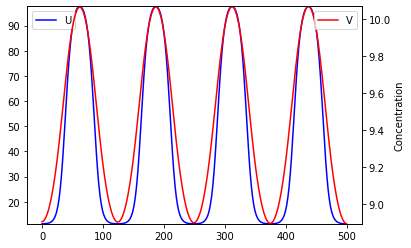

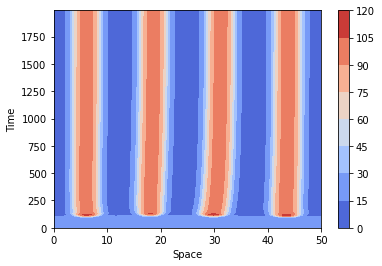

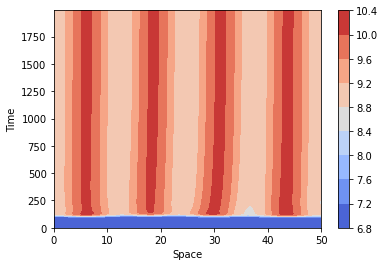

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1001074.0


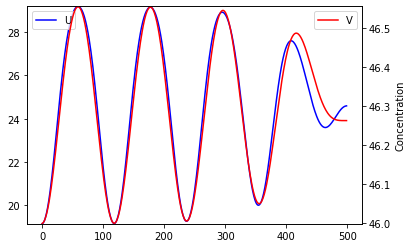

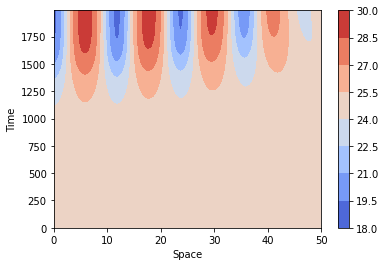

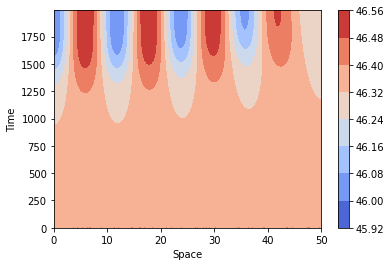

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

90984.0


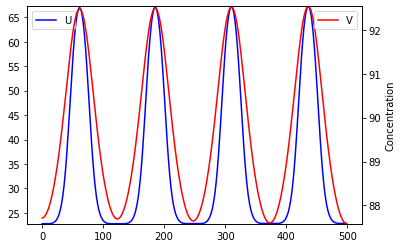

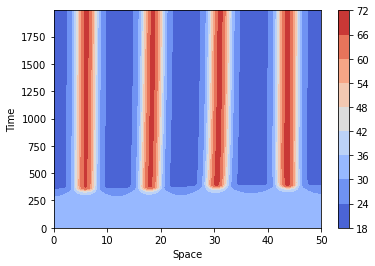

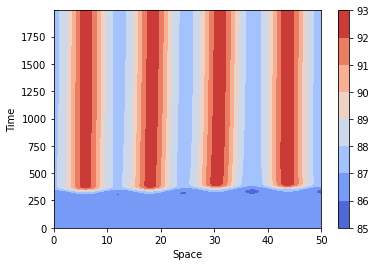

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1293491.0


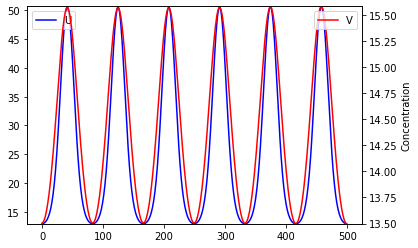

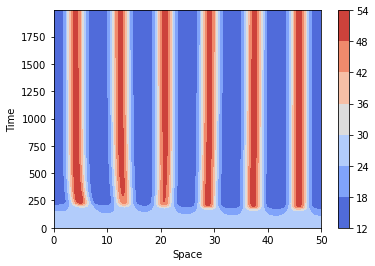

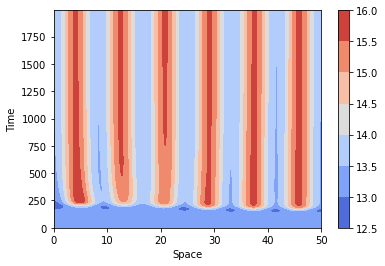

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

216783.0


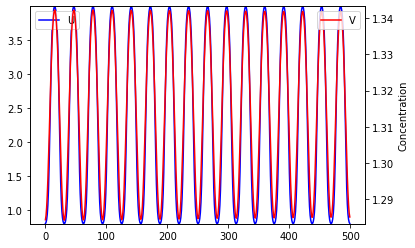

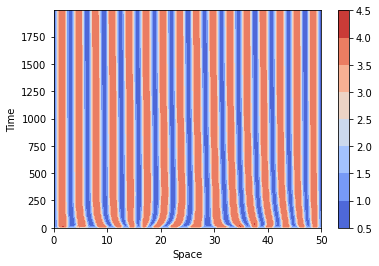

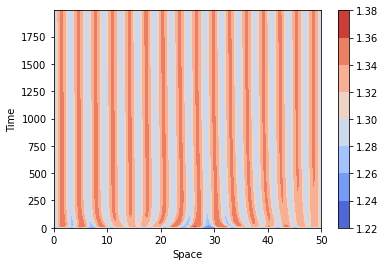

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1930331.2


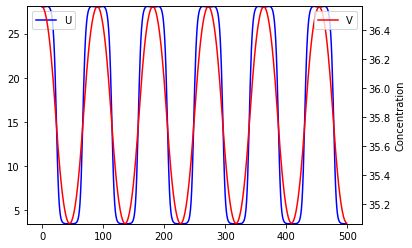

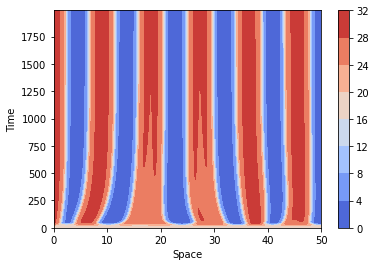

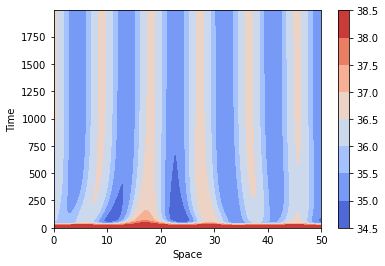

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

539955.1


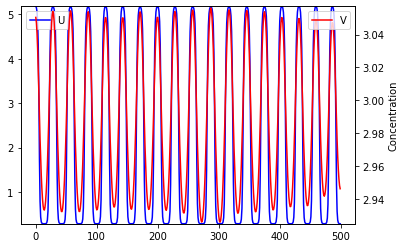

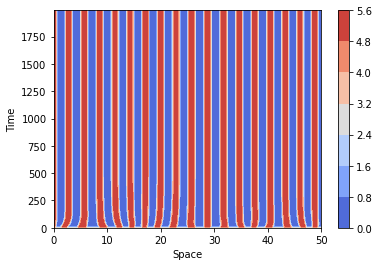

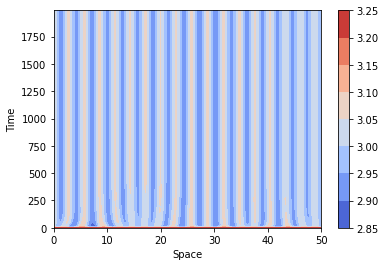

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

356348.0


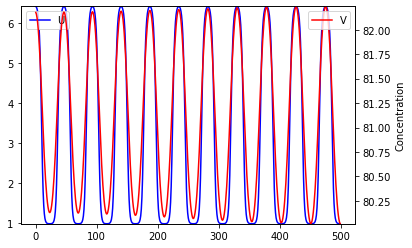

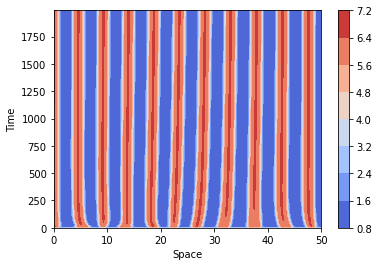

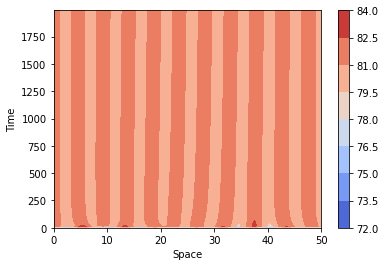

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1908473.0


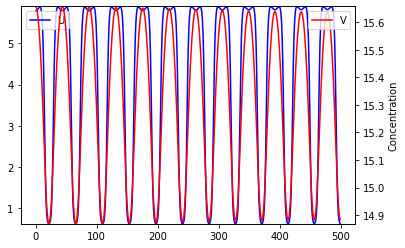

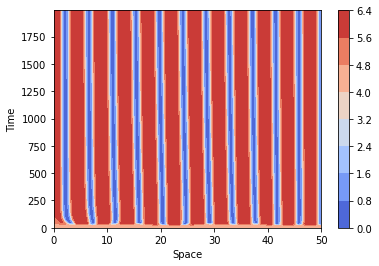

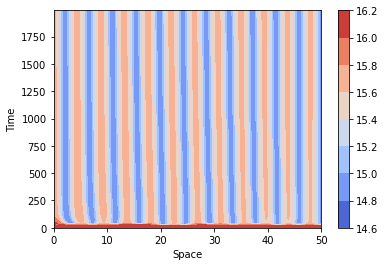

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

1715773.1


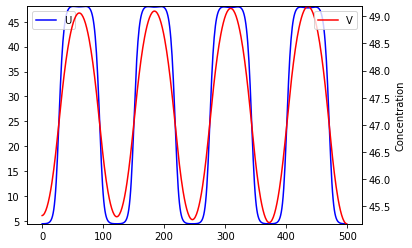

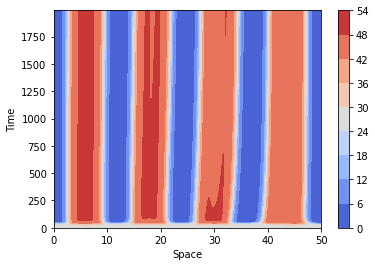

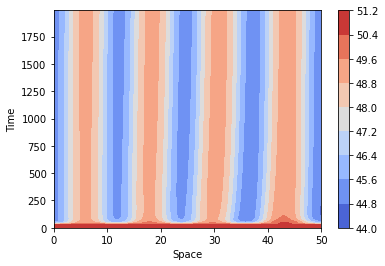

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1250091.0


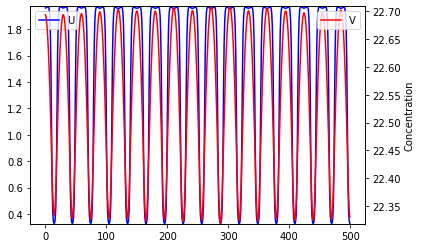

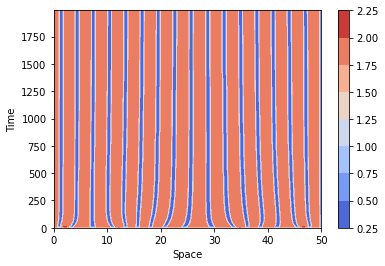

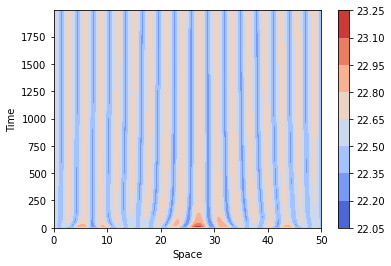

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

1091272.0


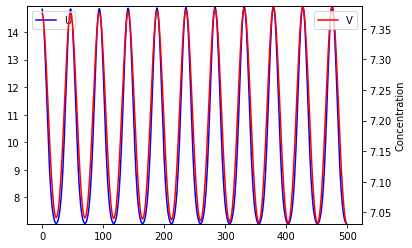

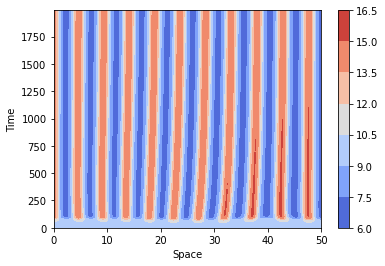

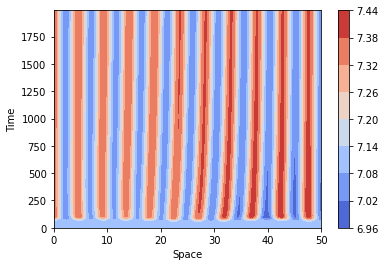

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

184525.2


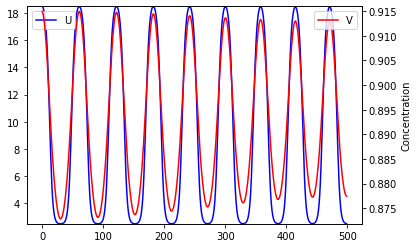

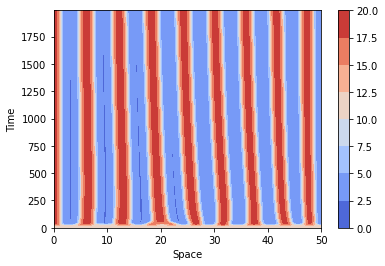

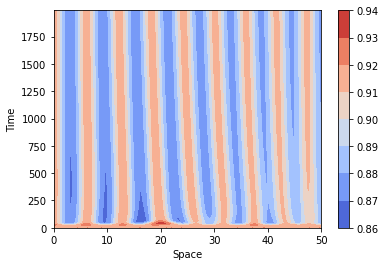

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

990171.0


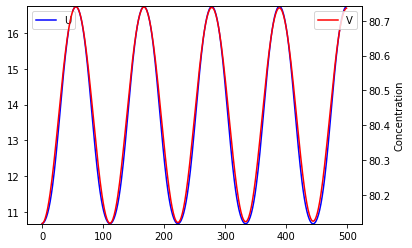

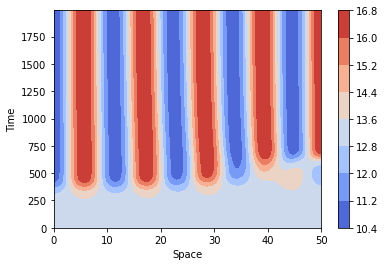

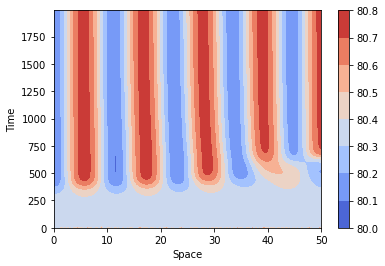

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1790718.0


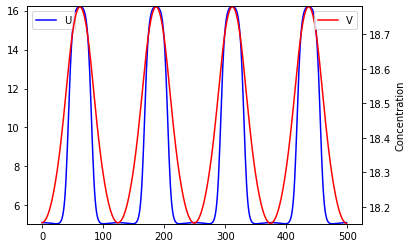

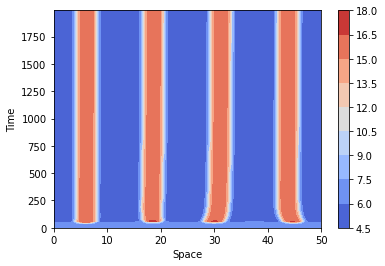

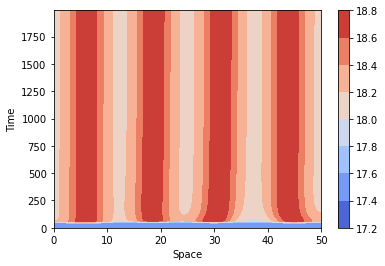

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

826275.1


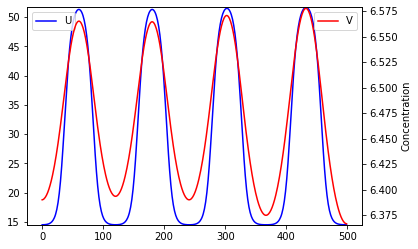

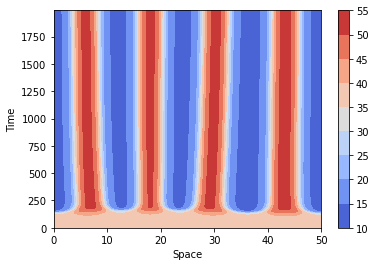

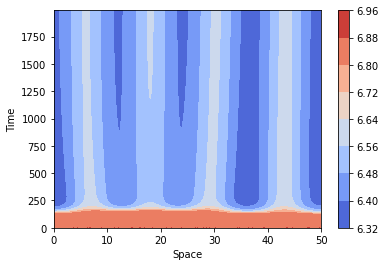

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

1001840.0


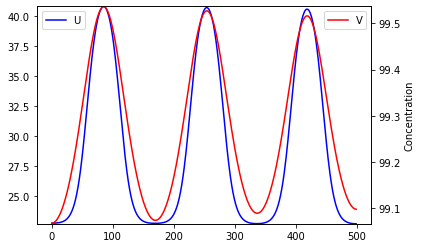

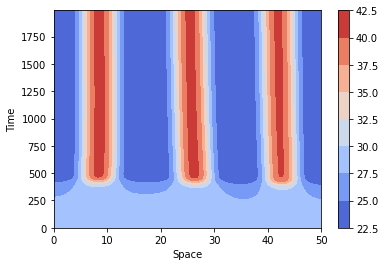

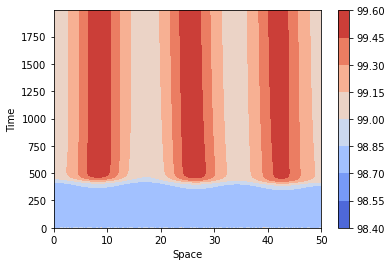

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

995222.0


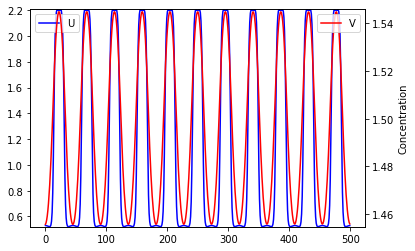

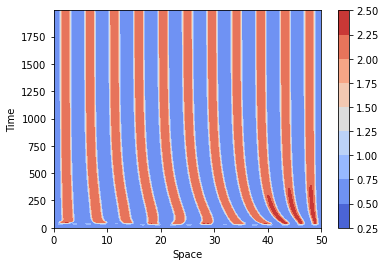

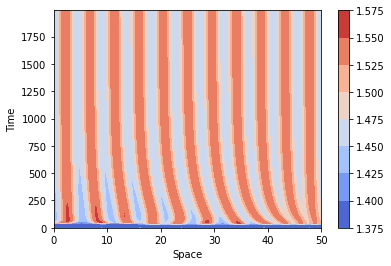

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

258407.0


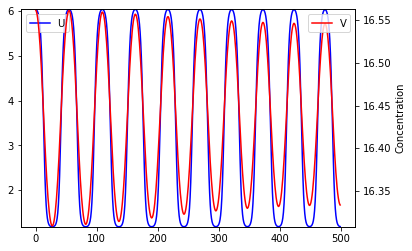

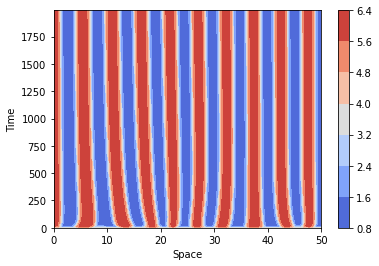

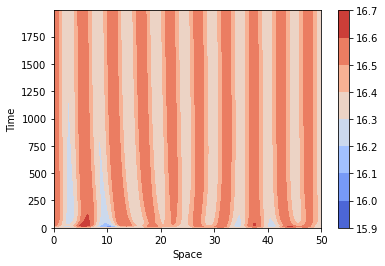

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1544038.0


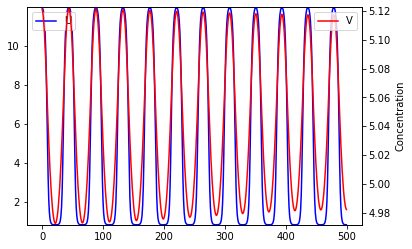

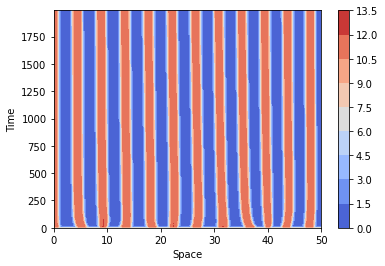

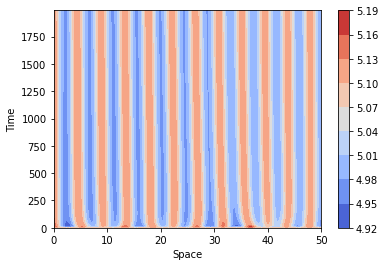

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1866454.0


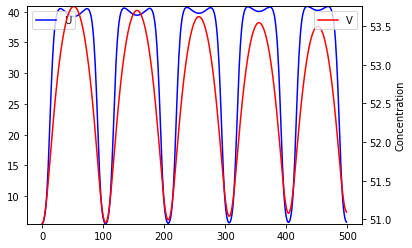

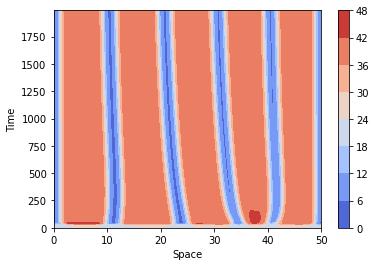

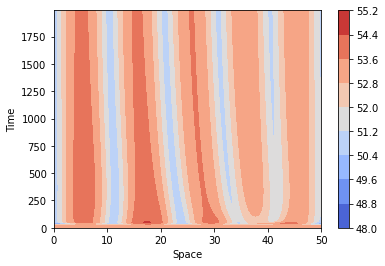

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

84010.0


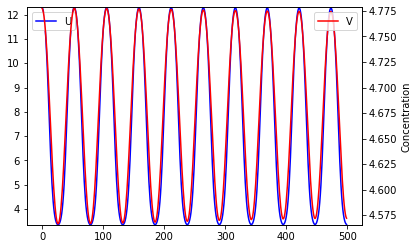

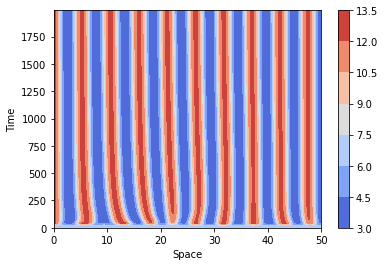

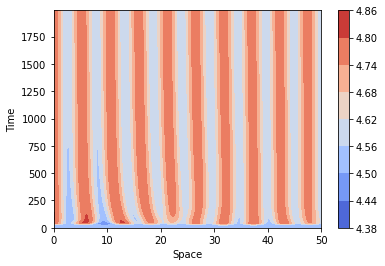

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1895355.0


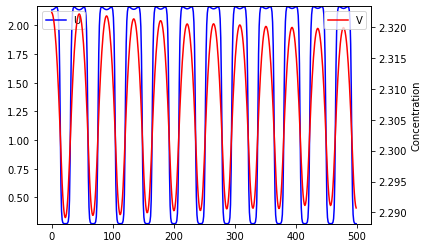

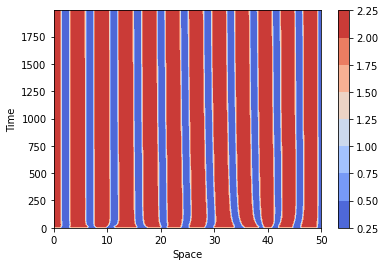

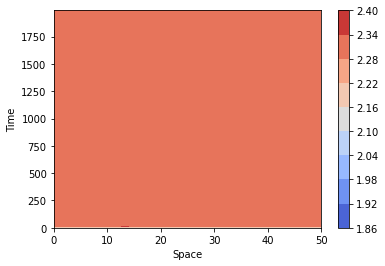

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

463801.1


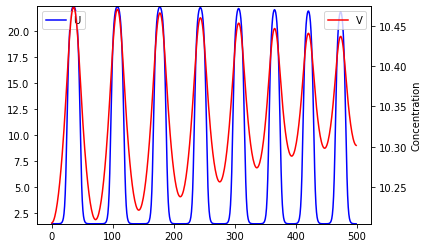

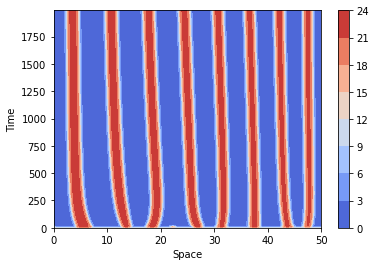

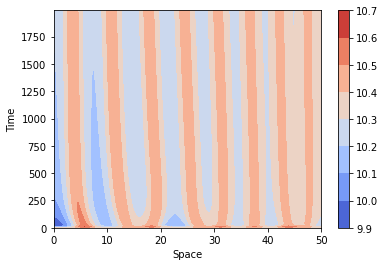

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

355879.0


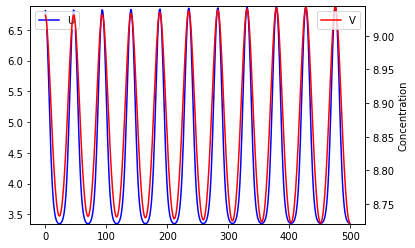

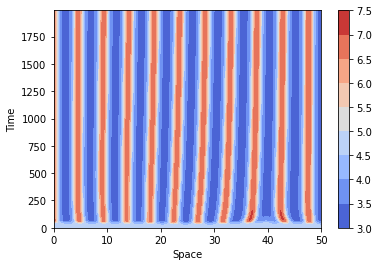

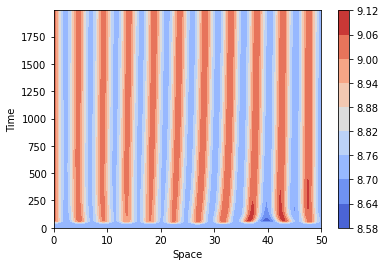

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1218783.2


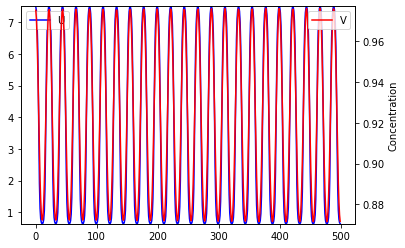

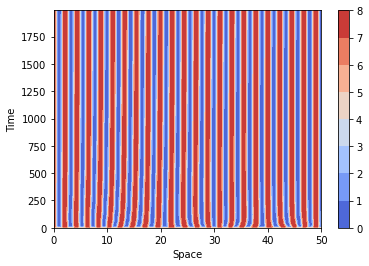

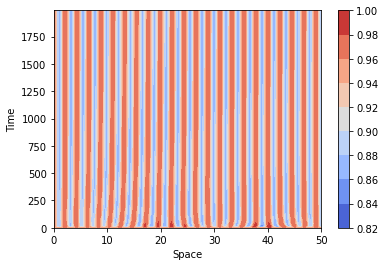

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

285368.0


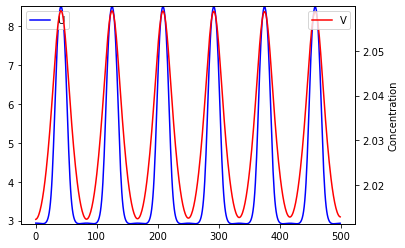

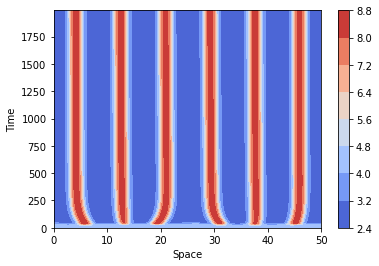

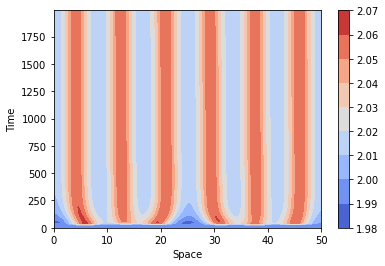

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

451003.0


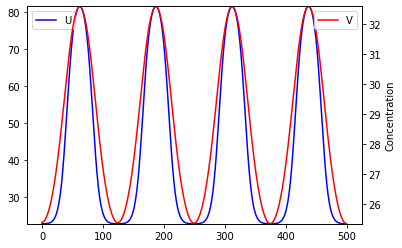

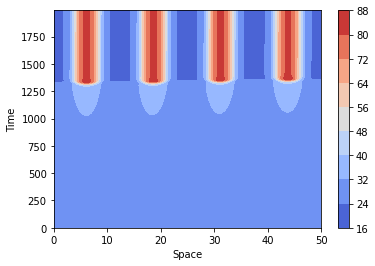

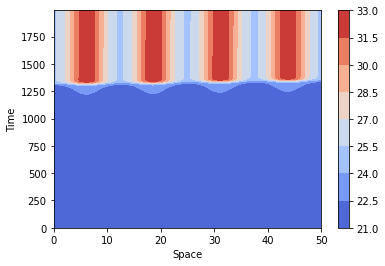

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

613055.0


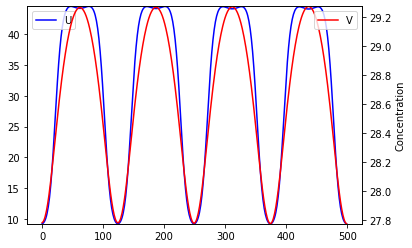

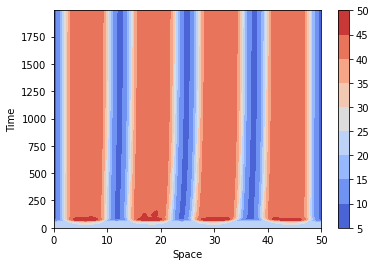

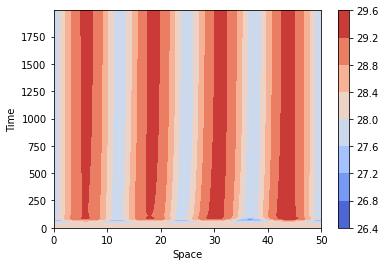

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1786149.0


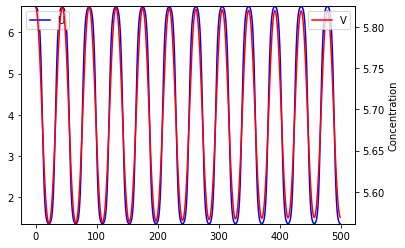

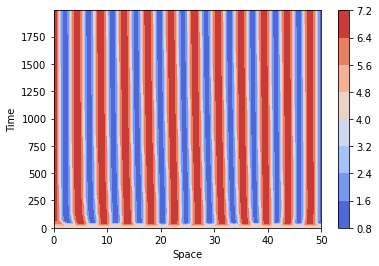

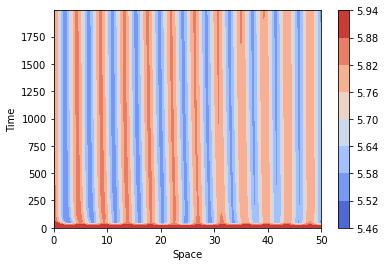

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1825388.0


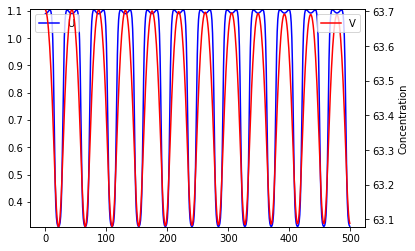

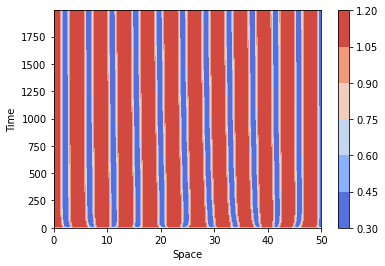

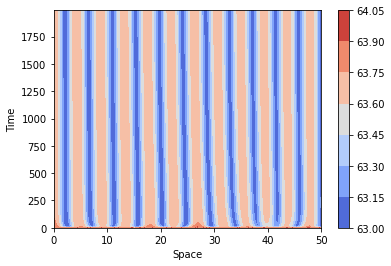

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

463063.0


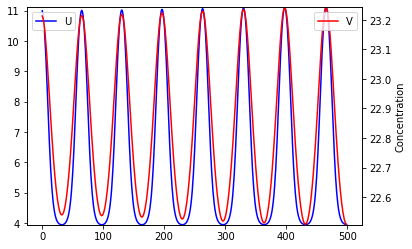

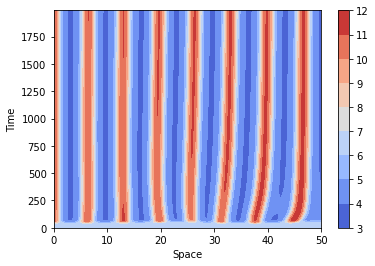

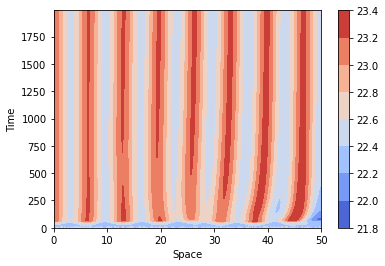

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

450041.0


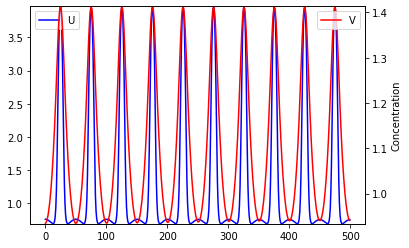

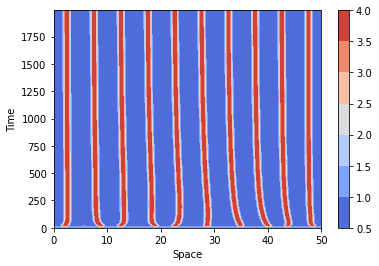

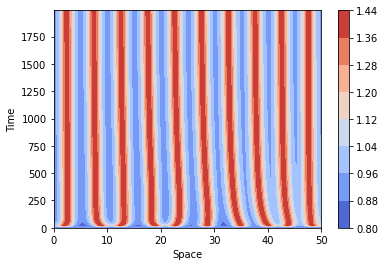

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

263943.0


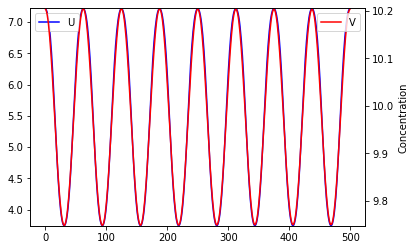

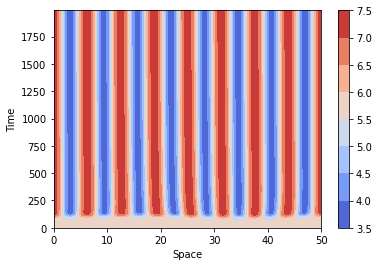

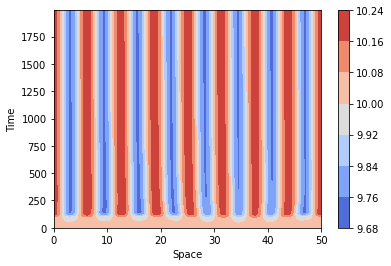

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1869232.0


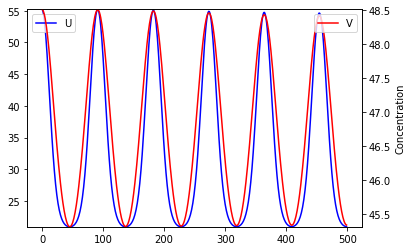

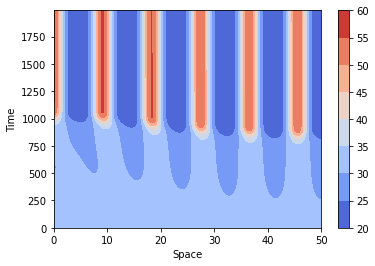

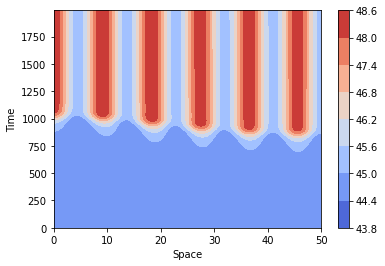

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

327974.0


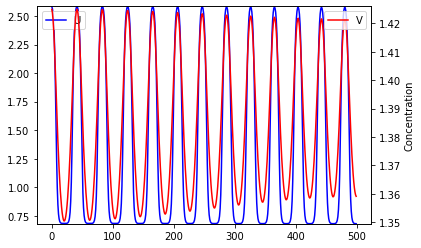

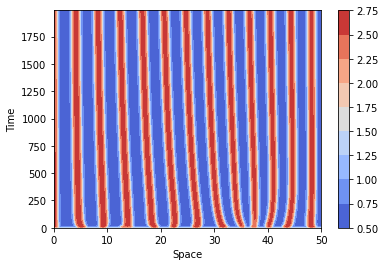

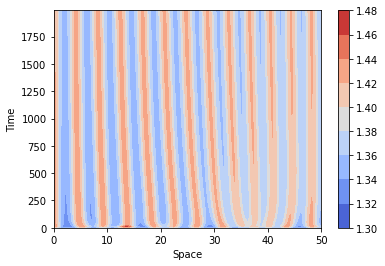

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1260669.0


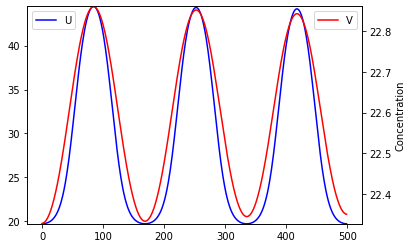

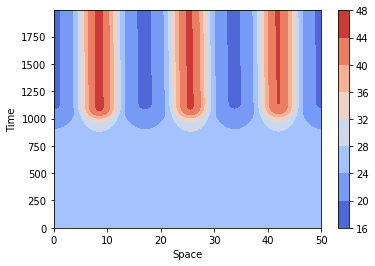

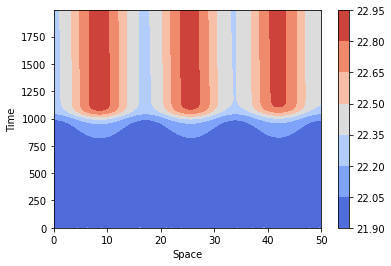

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

723976.0


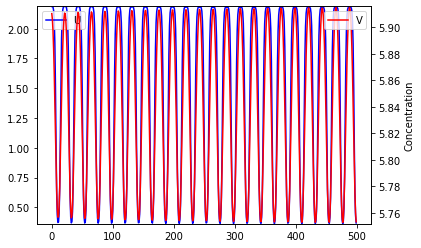

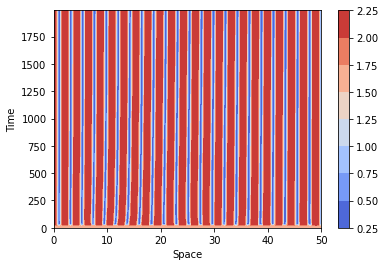

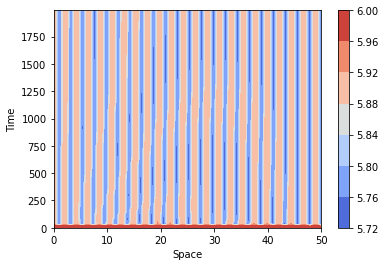

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

524876.1


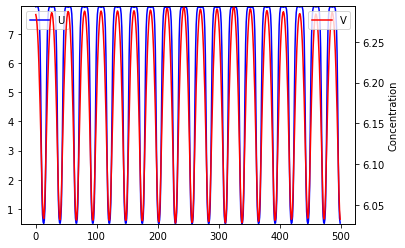

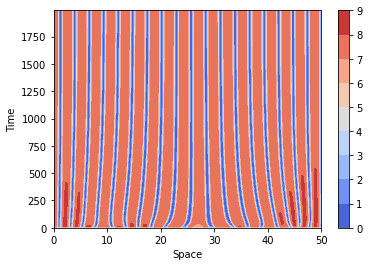

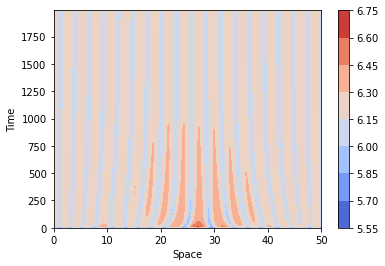

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

603114.0


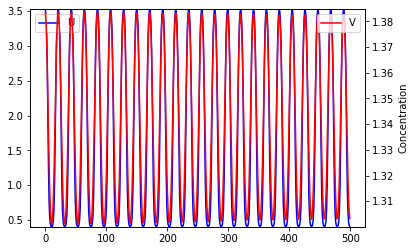

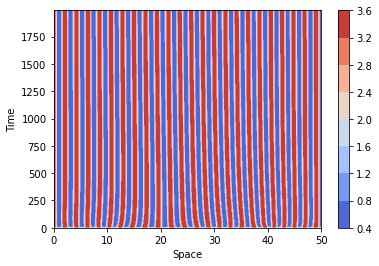

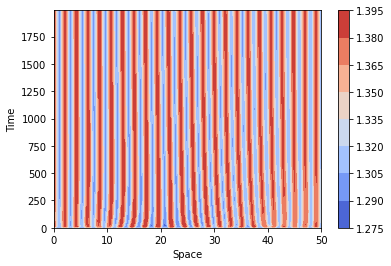

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1837204.0


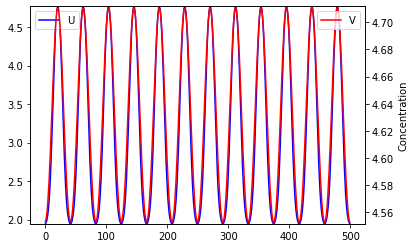

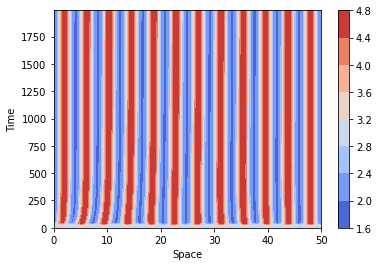

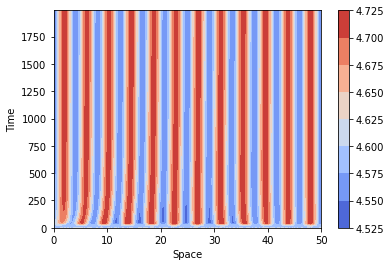

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1028218.0


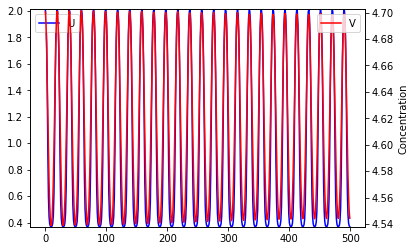

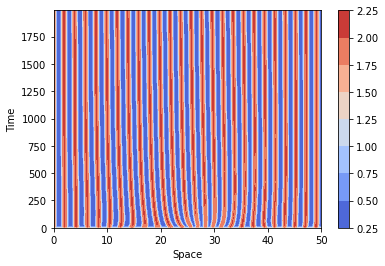

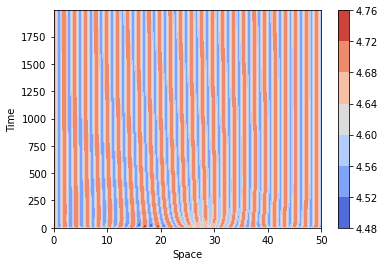

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1699290.0


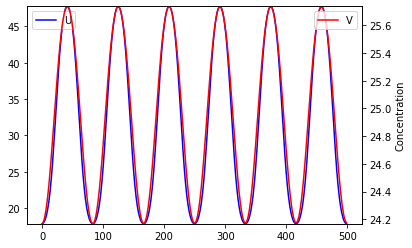

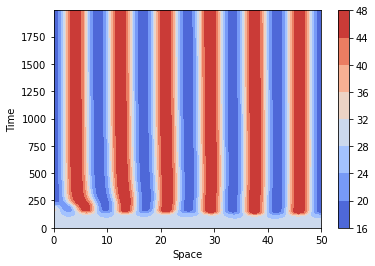

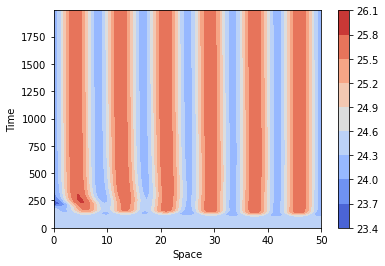

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

14414.0


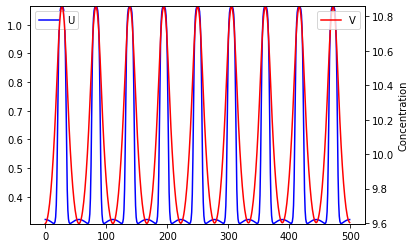

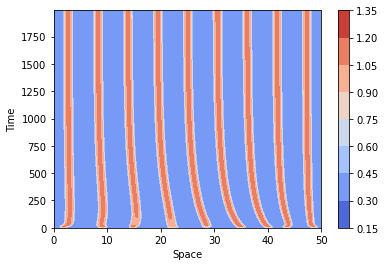

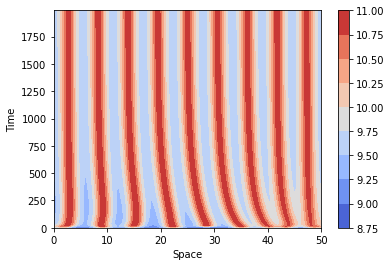

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

262251.0


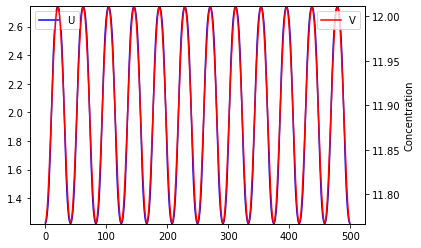

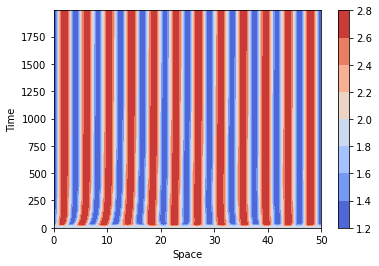

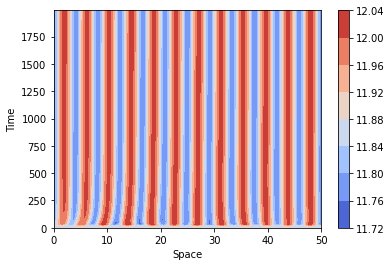

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

85037.0


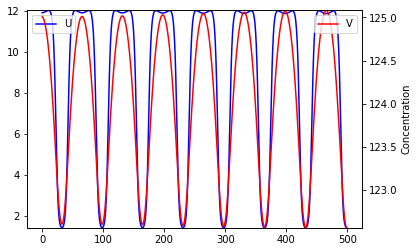

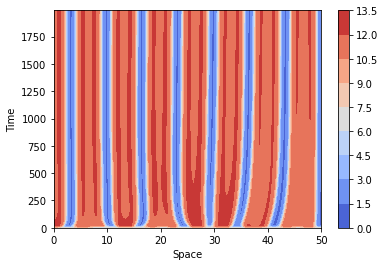

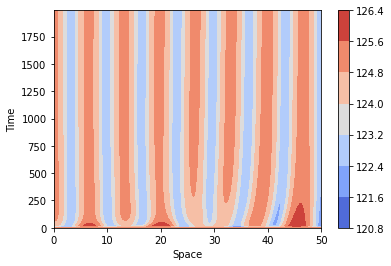

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

426078.0


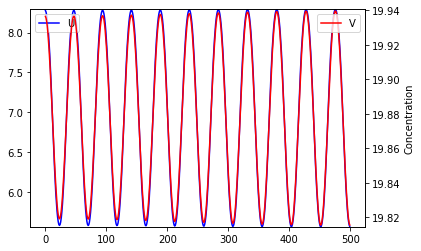

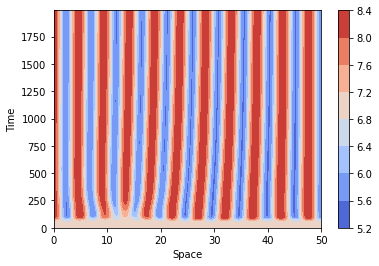

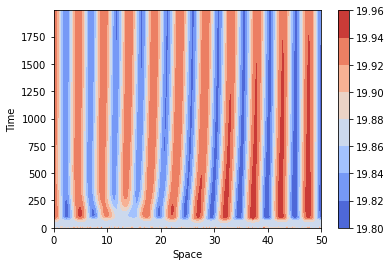

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

595947.0


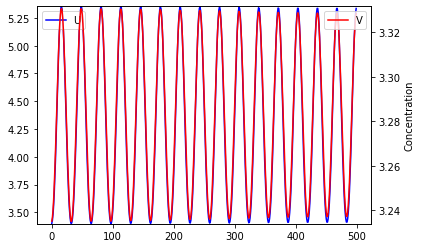

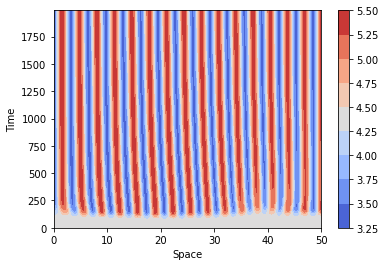

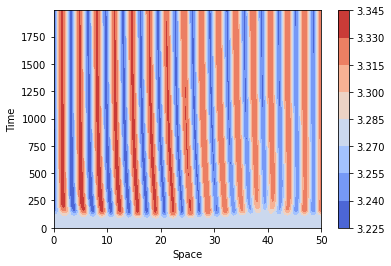

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

718455.0


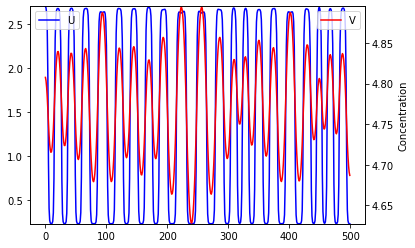

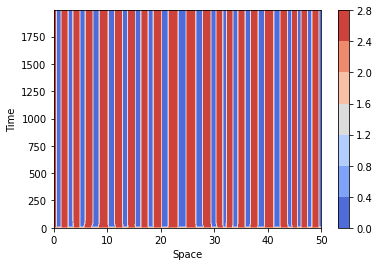

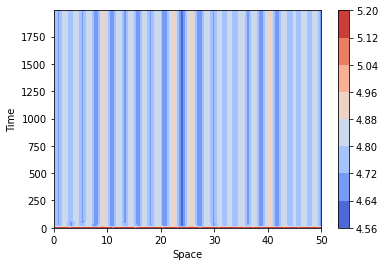

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1887693.1


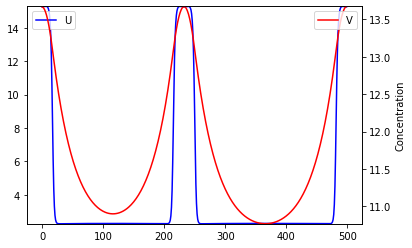

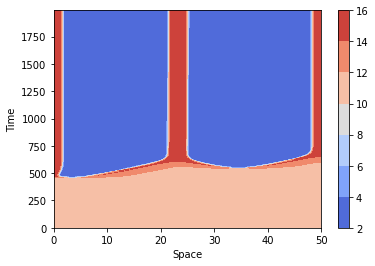

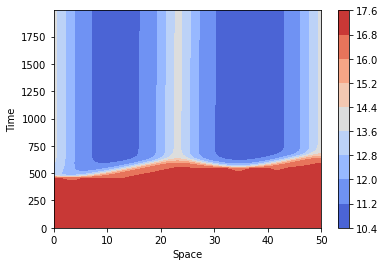

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

966474.0


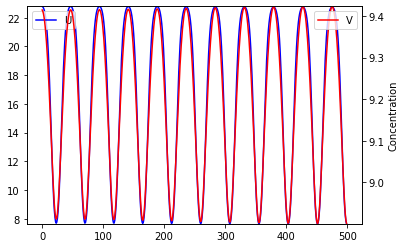

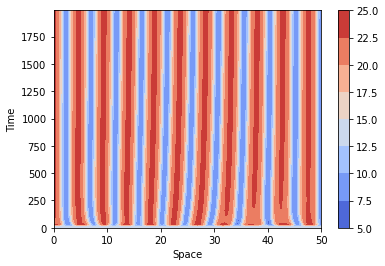

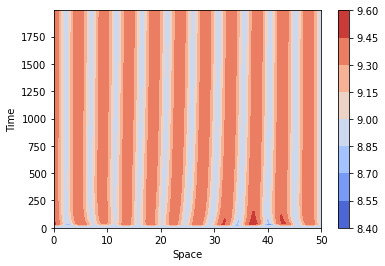

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

413840.0


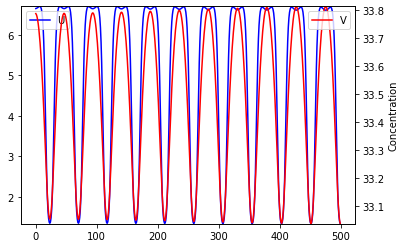

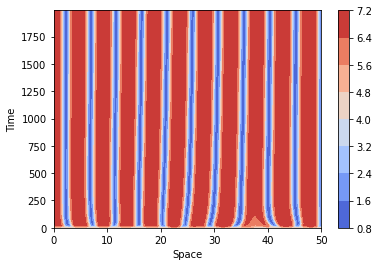

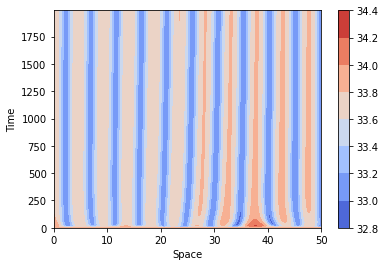

pattern:Stationary irregular pattern, converged:True, flat:False, regular:False 
-----------------------------------------

62715.0


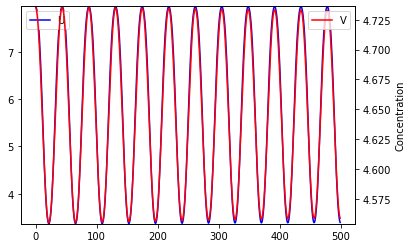

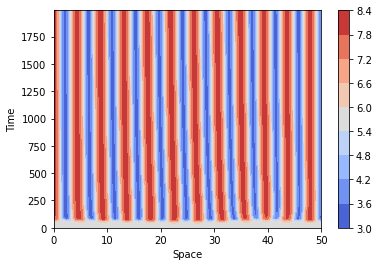

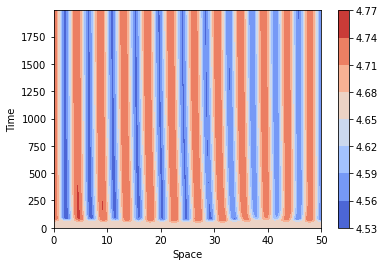

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1773690.2


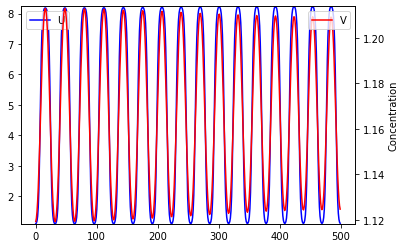

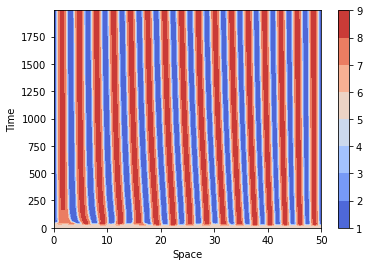

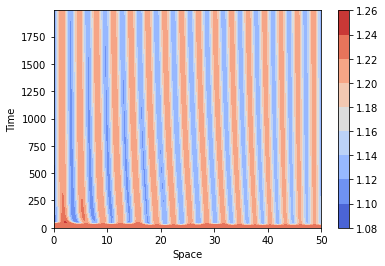

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

556242.0


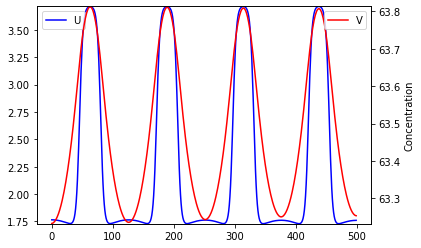

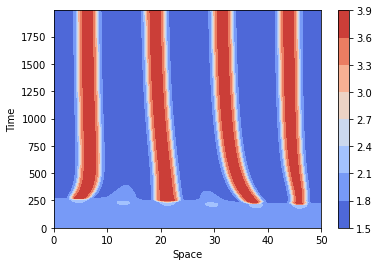

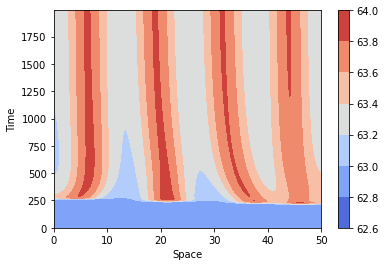

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

257730.0


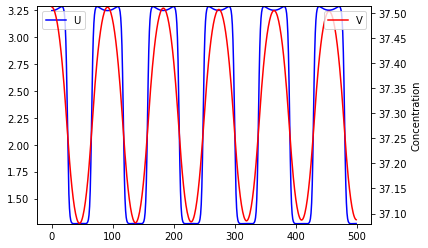

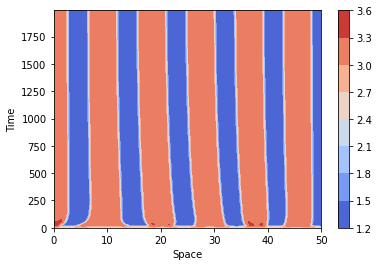

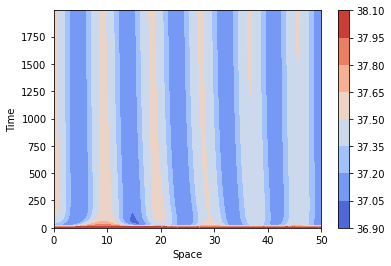

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1360649.0


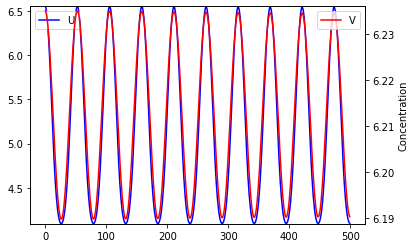

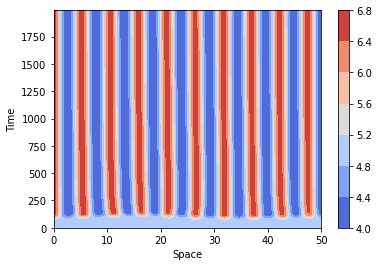

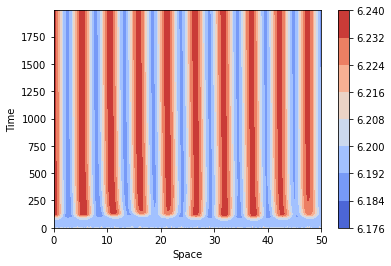

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

337635.0


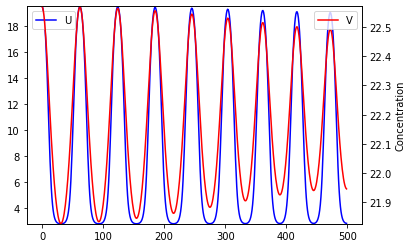

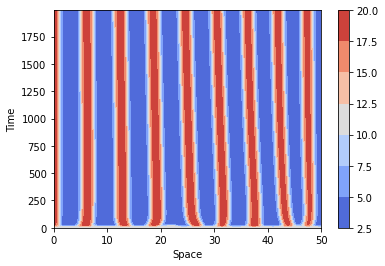

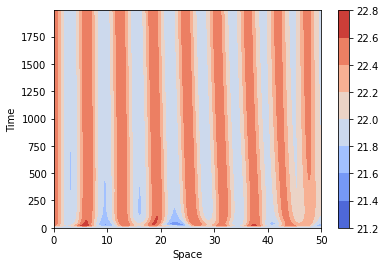

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1776690.0


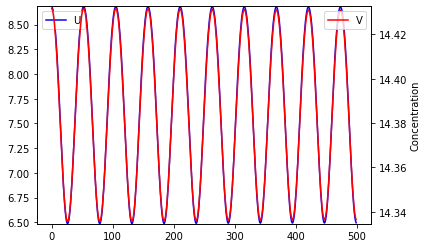

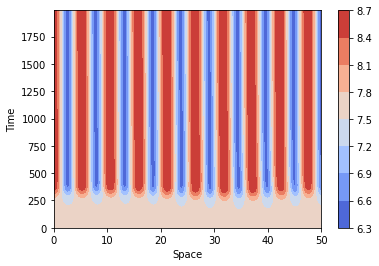

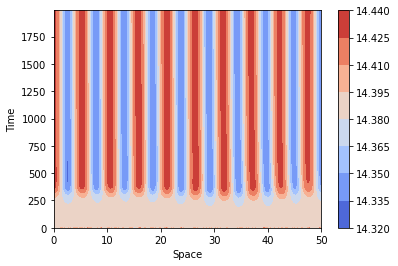

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1654084.0


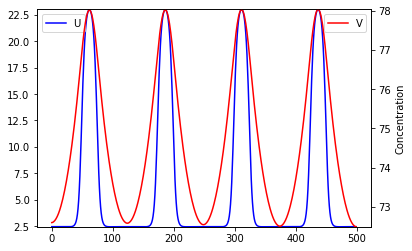

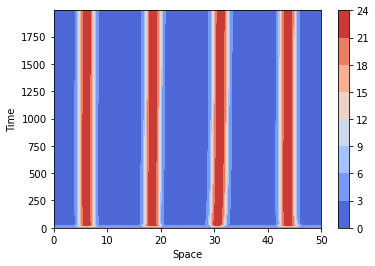

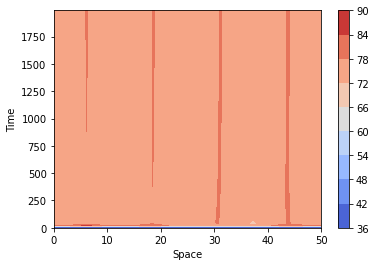

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1052576.0


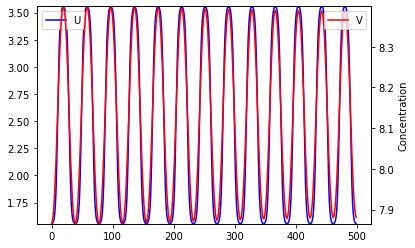

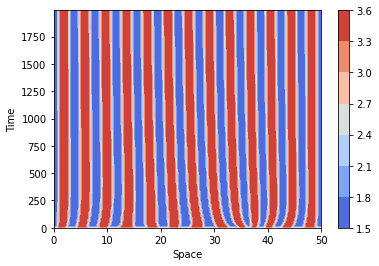

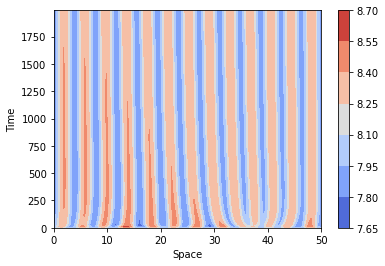

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1025722.0


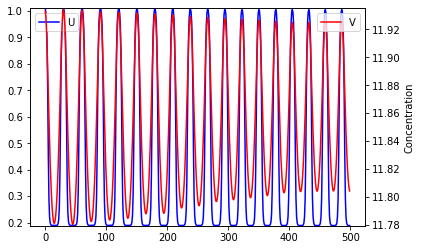

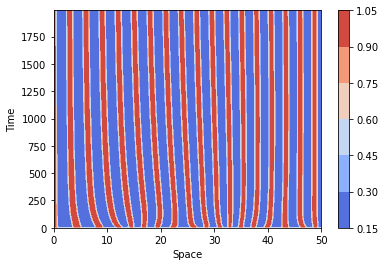

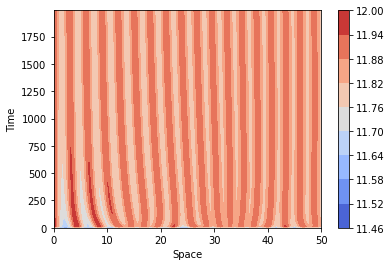

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------

1208004.1


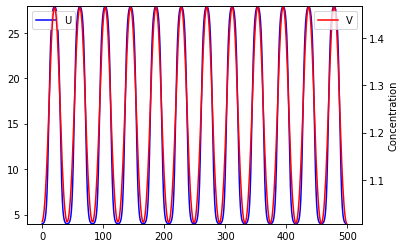

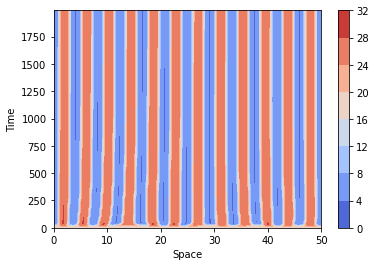

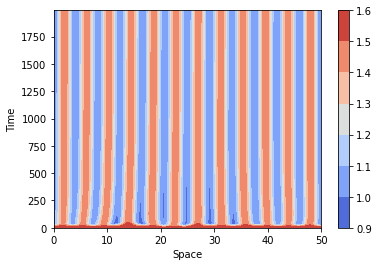

pattern:Stationary regular pattern, converged:True, flat:False, regular:True 
-----------------------------------------



In [39]:
mechanism = 'nogrowth'
folder = f'turinghill_variant{variant}'
filename= lambda mechanism, parID: 'circuit%s_variant%s_bc%s_%s_rate%s_ID%s_L%r_J%r_T%r_N%r'%(circuit_n,variant,boundaryCoeff, mechanism,rate,parID,L,J,T,N)
parID_list = pickle.load( open(modellingpath + '/growth/out/numerical/%s/simulation/%s/parID_list_%s.pkl'%(mechanism,folder,filename(mechanism, 'x')), "rb"))
nogrowth_pattern_list = []
nogrowth_pattern_dict ={}

for parID in parID_list:
   print(parID)
   U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/simulation/%s/2Dfinal_%s.pkl'%(mechanism,folder,filename(mechanism, parID)), "rb"))
   U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/simulation/%s/2Drecord_%s.pkl'%(mechanism,folder,filename(mechanism, parID)), "rb"))
   pattern, converged, flat, regular = patternClassification(U_final, U_record)
   nogrowth_pattern_list.append(pattern)
   nogrowth_pattern_dict[parID] = pattern
   plot1D(U_final, savefig=False,filename='')
   plt.show()
   surfpattern(U_record, [x_grid, reduced_t_grid], 'linear',morphogen=0, rate=0, savefig=False,filename='',logResults=False,normalize=False)
   plt.show()
   surfpattern(U_record, [x_grid, reduced_t_grid], 'linear',  morphogen=1, rate=0, savefig=False,filename='',logResults=False,normalize=False)
   plt.show()
   print(f'pattern:{pattern}, converged:{ converged}, flat:{ flat}, regular:{regular} ')
   print('-----------------------------------------')
   print('')

In [40]:
count = pd.Series(nogrowth_pattern_list).value_counts()
count

Stationary regular pattern      76
Stationary irregular pattern    14
Homogeneous                      1
dtype: int64

## Edgegrowth2

In [41]:

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)+1e-8)

def countPeaks(U, showPlot1D=True):
    peaks = [0,0]
    peaks[0], _ = find_peaks(U[0], prominence=0.1)
    peaks[1], _ = find_peaks(U[1], prominence=0.1)
    if showPlot1D == True:
        plot1D(U,plotPeaks=True, peaks=peaks)

    return peaks

def patternClassification(U_final, U_record, normalize=True):


    #check if regular
    U_final_norm = [NormalizeData(U) for U in U_final]
    peaks = countPeaks(U_final_norm, showPlot1D=False)

    print(f'peaks:{len(peaks[0])}')
    n_peaks = len(peaks[0])

    if n_peaks==0 or n_peaks==1:
        pattern = 'no pattern'
    if n_peaks ==2:
        pattern = 'boundary pattern'
    if n_peaks ==3:
        pattern = 'weak pattern'
    if n_peaks == 4:
        pattern = 'intermediate pattern'
    if n_peaks > 4:
        pattern  = 'strong pattern'

    return pattern



    # return pattern, converged, flat, regular

104782.0
peaks:4


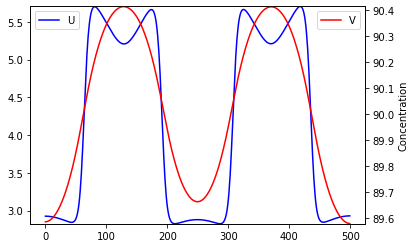

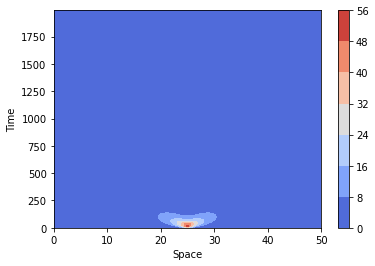

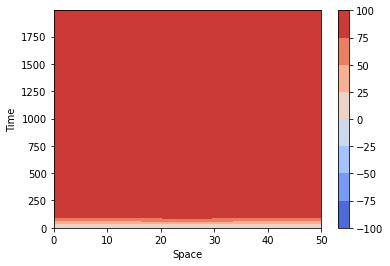

-----------------------------------------

1748606.0
peaks:0


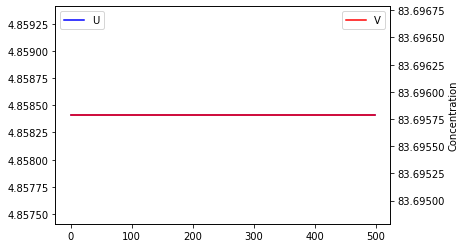

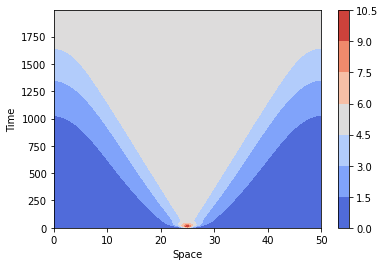

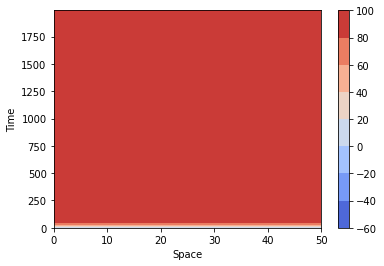

-----------------------------------------

1471198.2
peaks:0


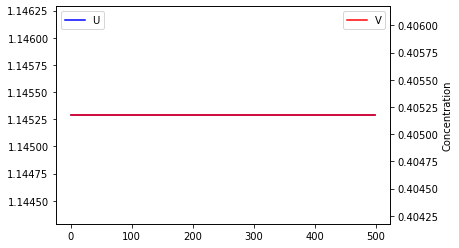

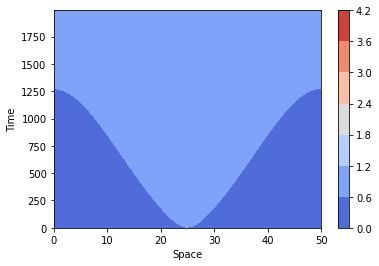

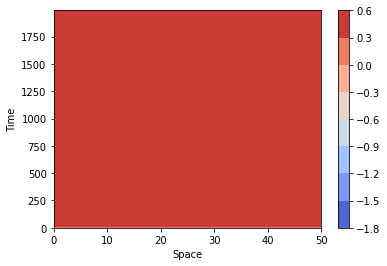

-----------------------------------------

942691.1
peaks:0


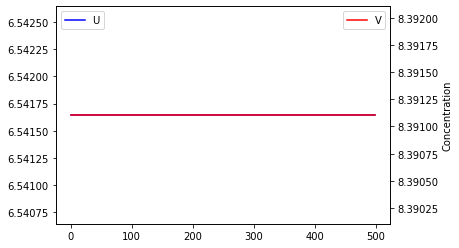

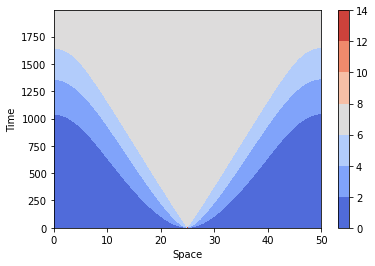

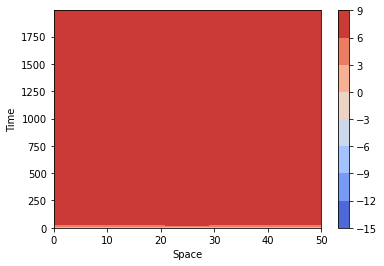

-----------------------------------------

903128.0
peaks:3


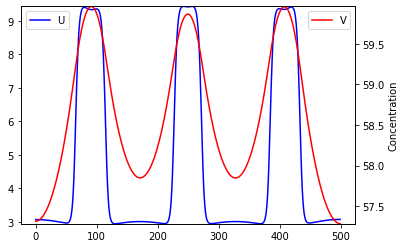

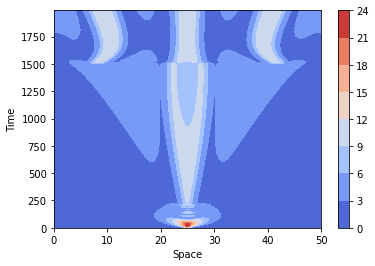

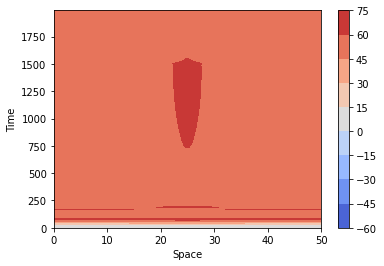

-----------------------------------------

1396843.0
peaks:4


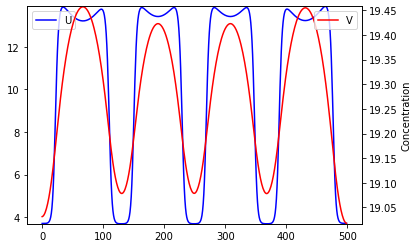

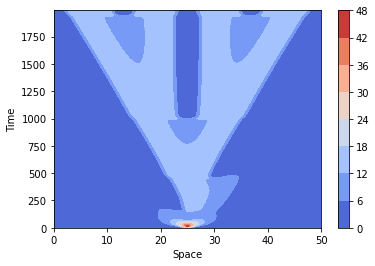

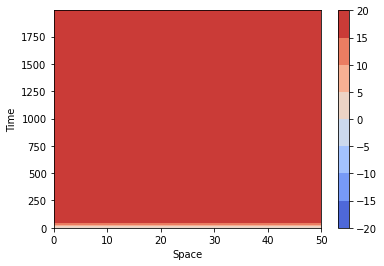

-----------------------------------------

1928281.0
peaks:3


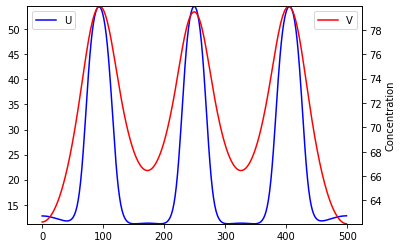

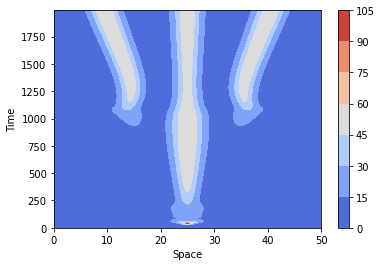

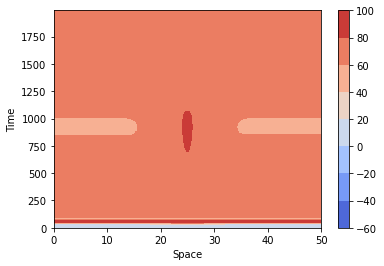

-----------------------------------------

195855.1
peaks:0


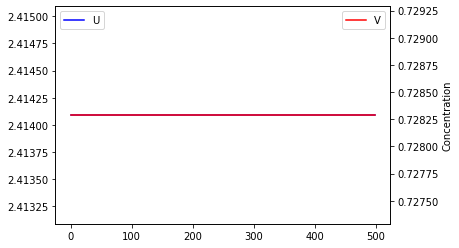

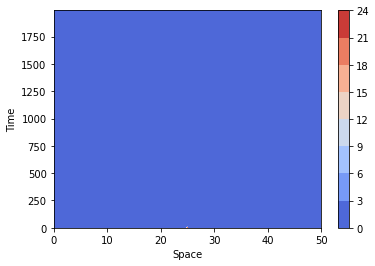

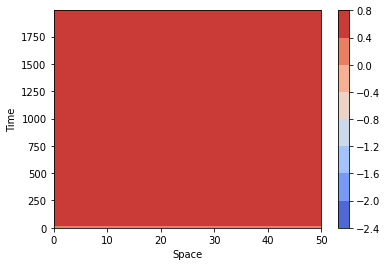

-----------------------------------------

1042553.0
peaks:8


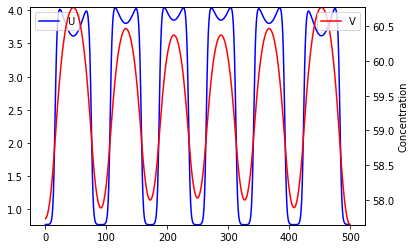

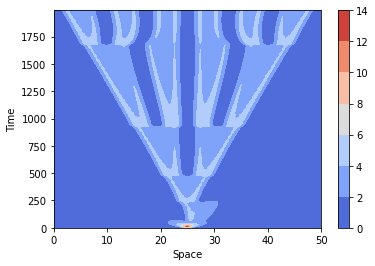

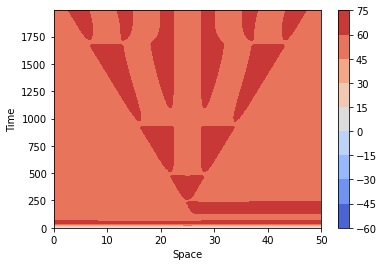

-----------------------------------------

1287827.0
peaks:4


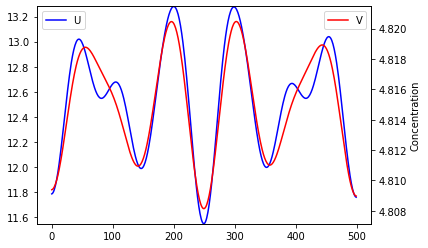

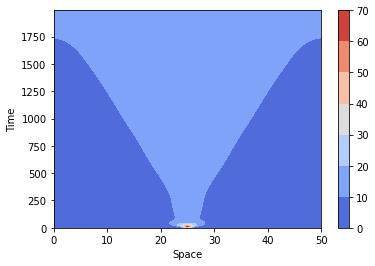

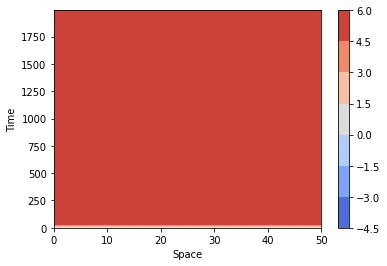

-----------------------------------------

1917168.0
peaks:4


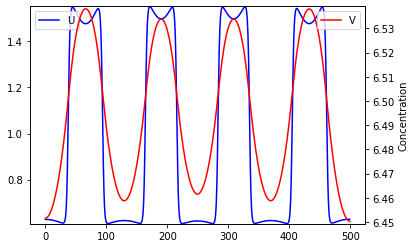

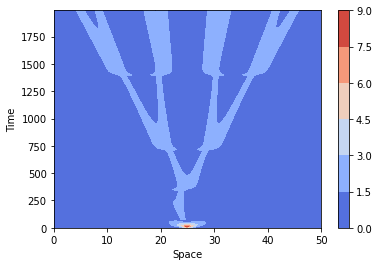

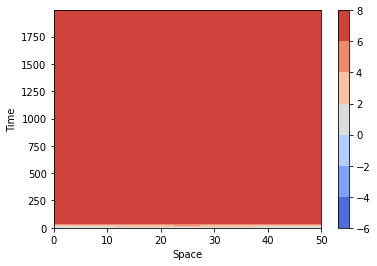

-----------------------------------------

202243.0
peaks:4


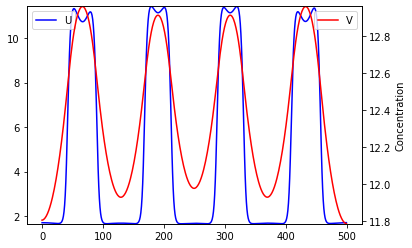

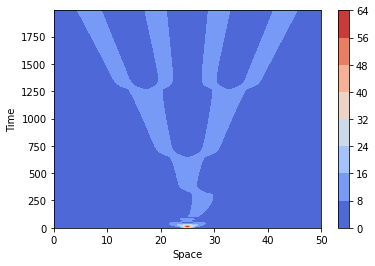

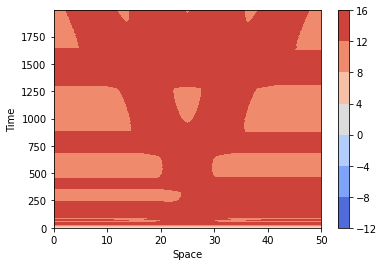

-----------------------------------------

639624.0
peaks:14


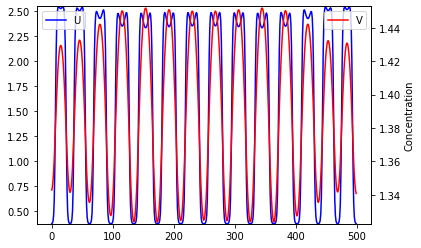

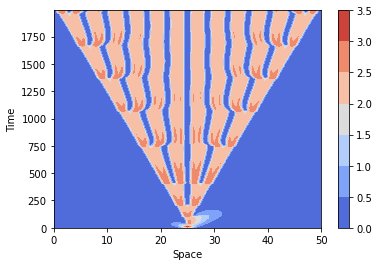

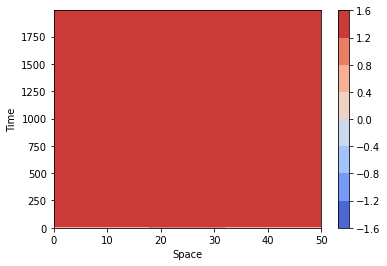

-----------------------------------------

511906.0
peaks:3


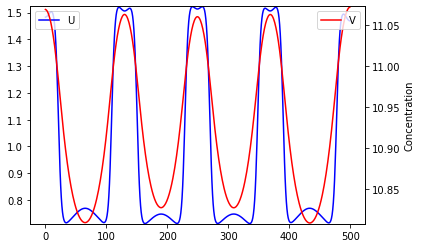

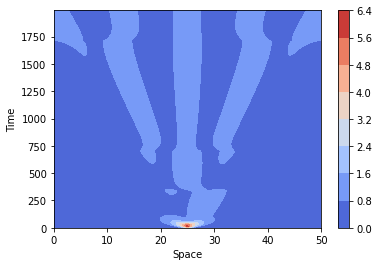

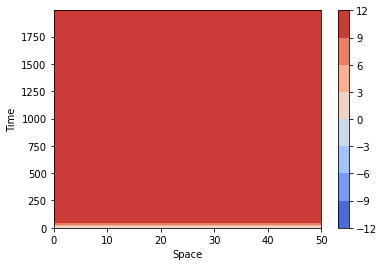

-----------------------------------------

775319.1
peaks:0


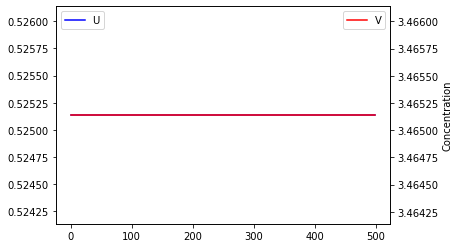

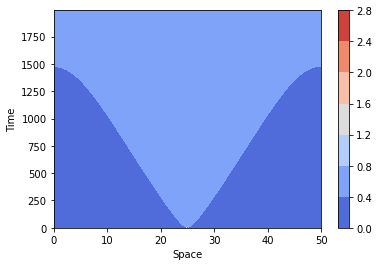

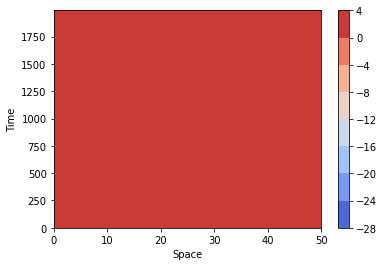

-----------------------------------------

211773.0
peaks:3


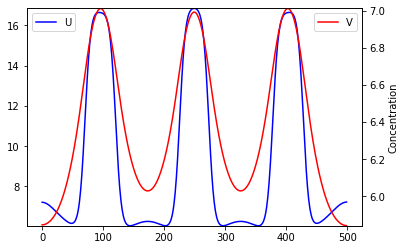

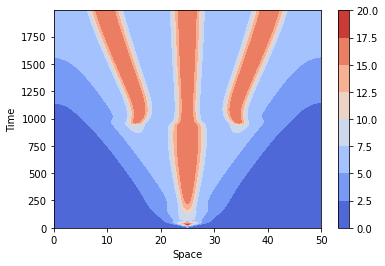

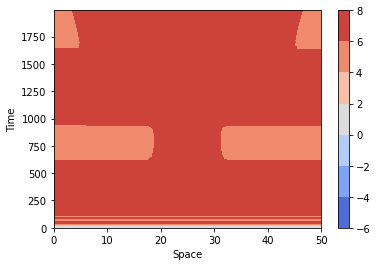

-----------------------------------------

129165.0
peaks:6


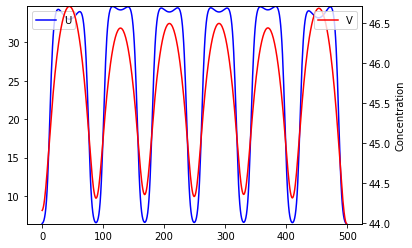

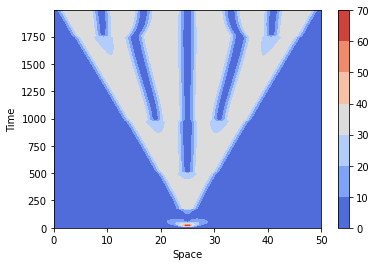

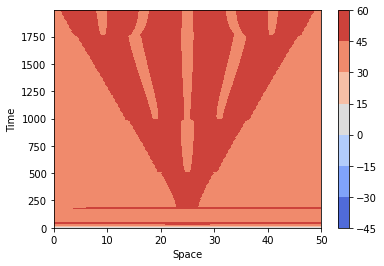

-----------------------------------------

571384.0
peaks:10


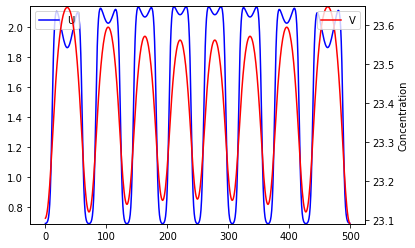

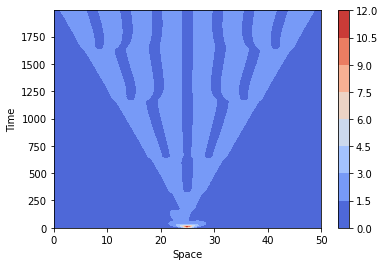

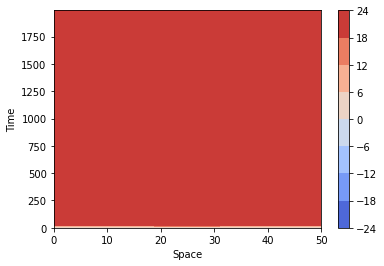

-----------------------------------------

1462422.0
peaks:3


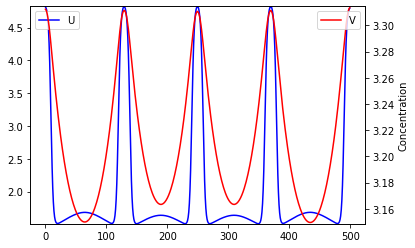

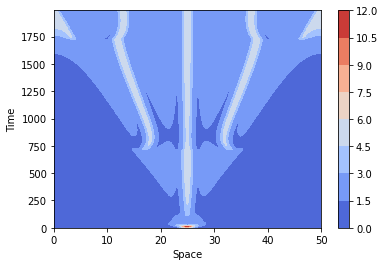

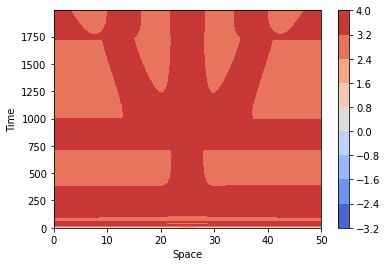

-----------------------------------------

584464.0
peaks:0


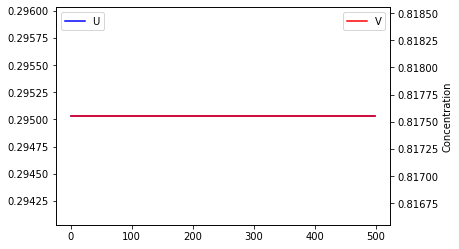

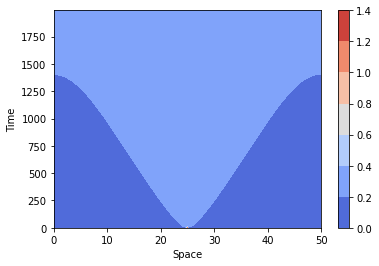

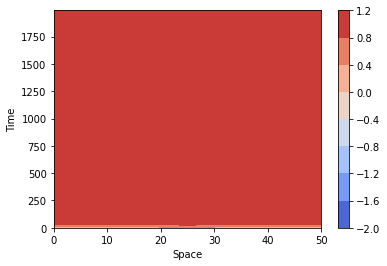

-----------------------------------------

1442645.0
peaks:6


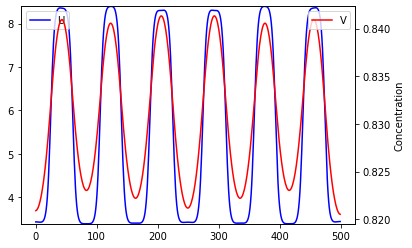

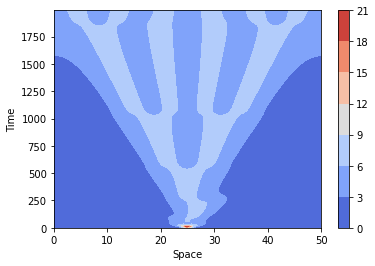

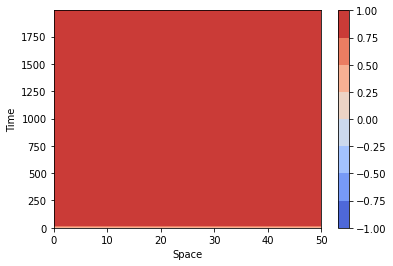

-----------------------------------------

751715.0
peaks:6


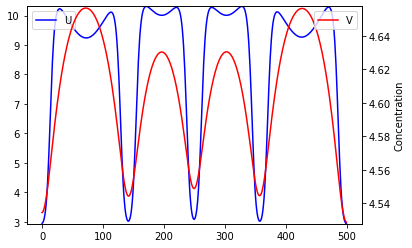

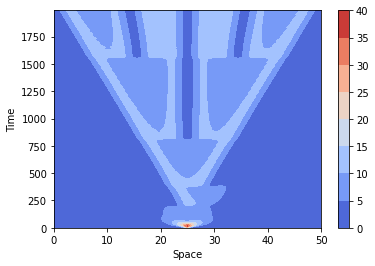

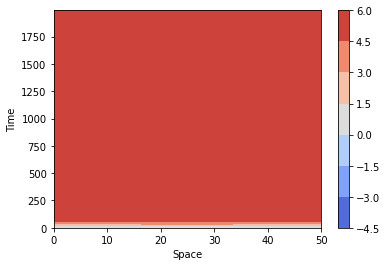

-----------------------------------------

284887.0
peaks:16


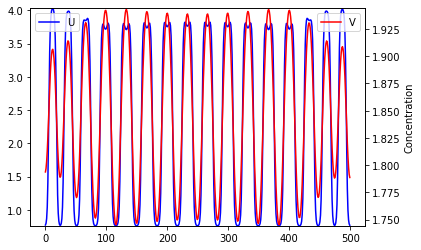

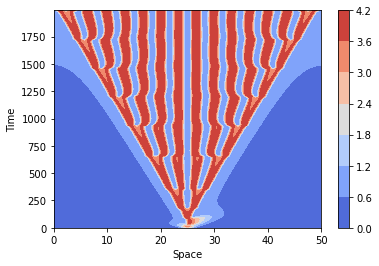

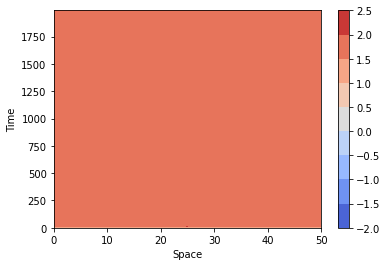

-----------------------------------------

1697541.0
peaks:9


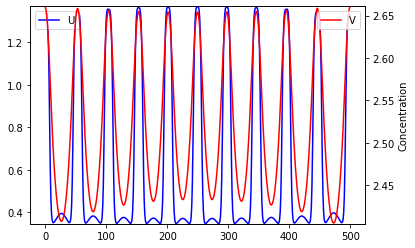

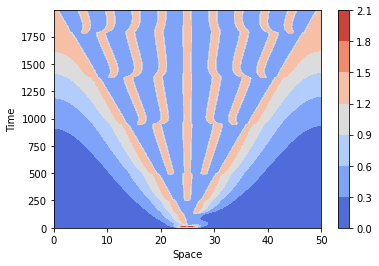

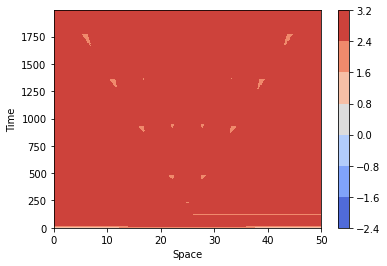

-----------------------------------------

518029.0
peaks:16


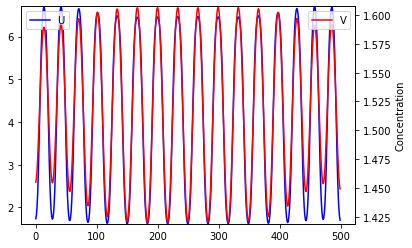

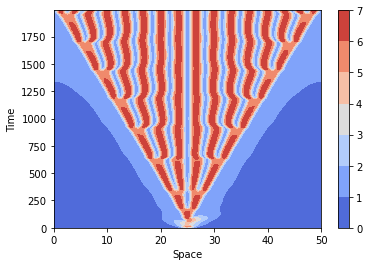

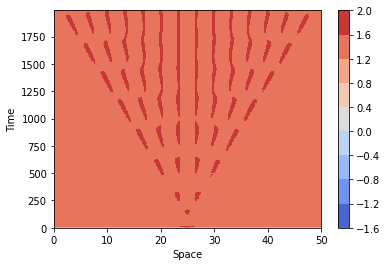

-----------------------------------------

1230834.1
peaks:0


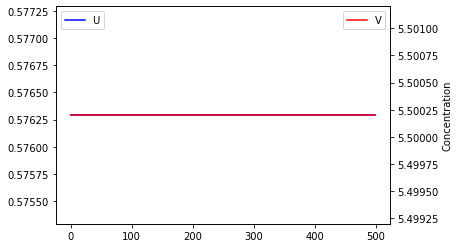

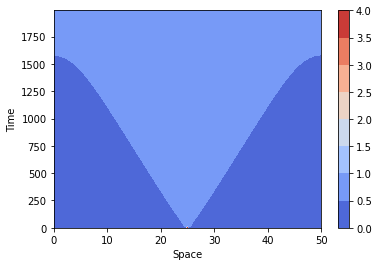

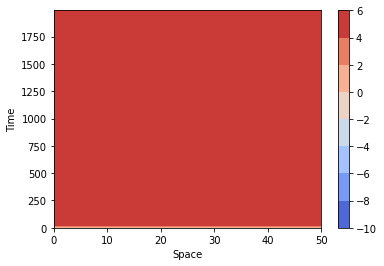

-----------------------------------------

164798.0
peaks:18


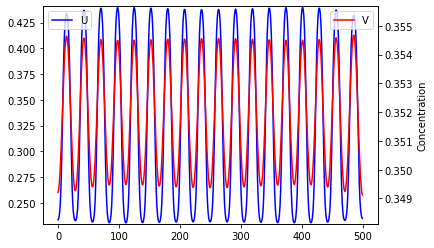

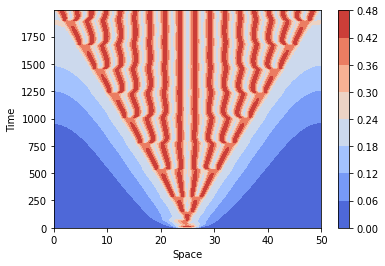

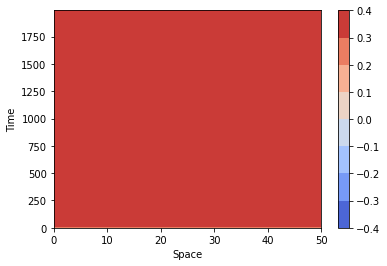

-----------------------------------------

1061542.0
peaks:5


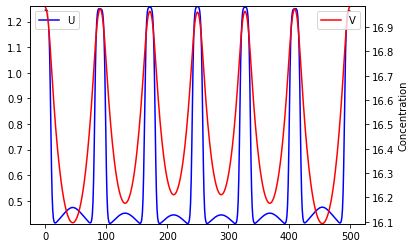

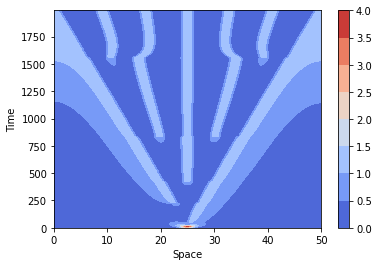

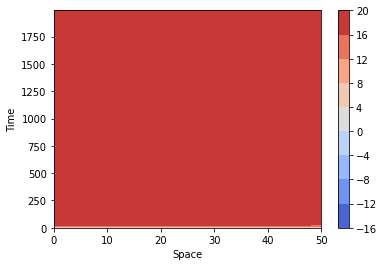

-----------------------------------------

1280327.0
peaks:4


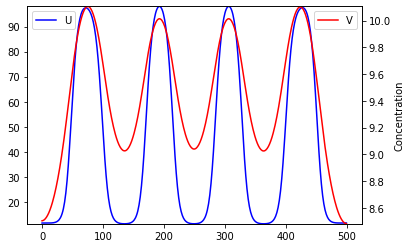

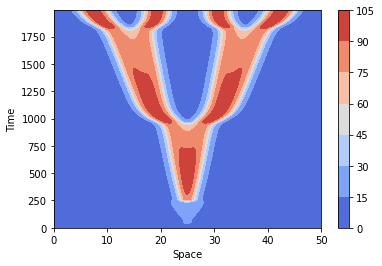

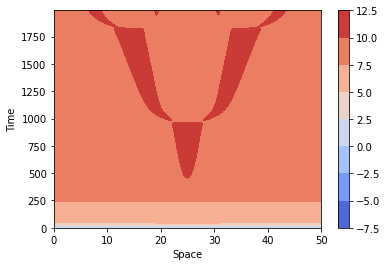

-----------------------------------------

1001074.0
peaks:5


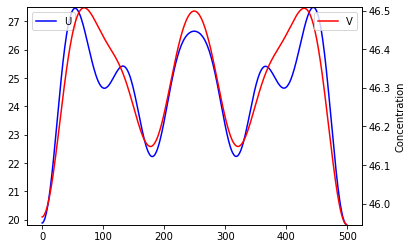

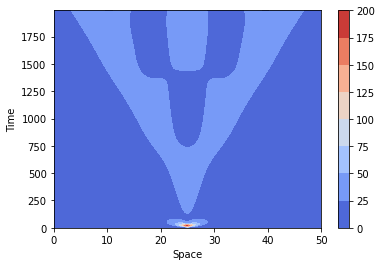

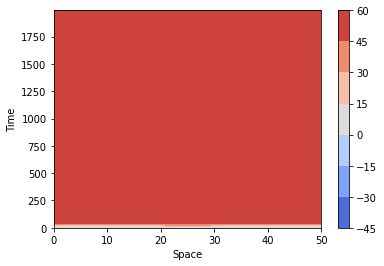

-----------------------------------------

90984.0
peaks:3


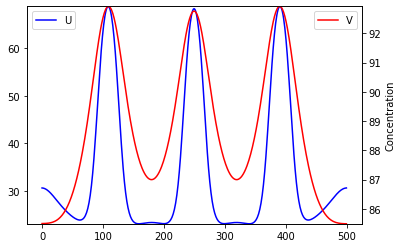

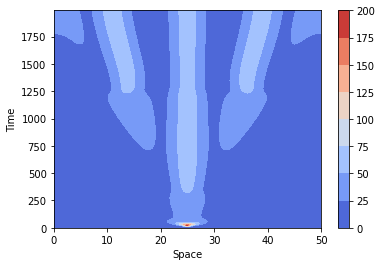

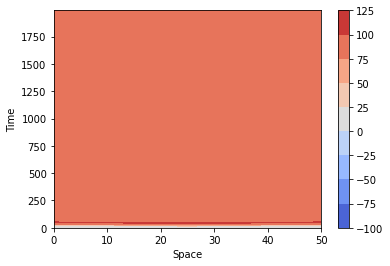

-----------------------------------------

1293491.0
peaks:3


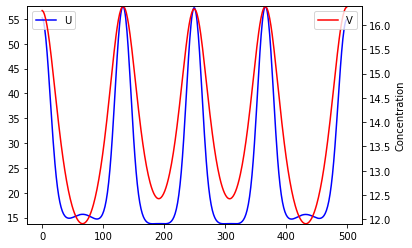

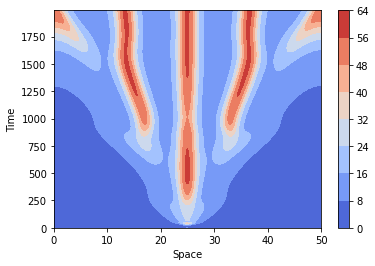

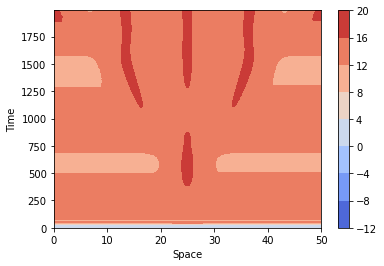

-----------------------------------------

216783.0
peaks:12


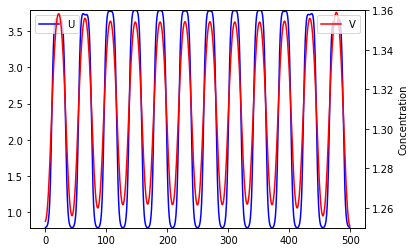

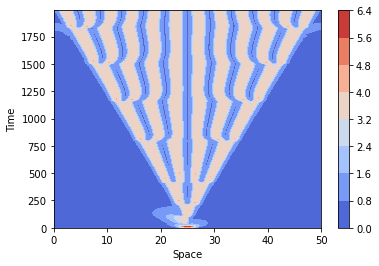

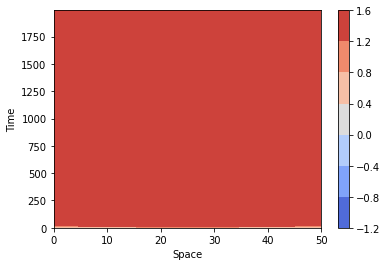

-----------------------------------------

1930331.2
peaks:0


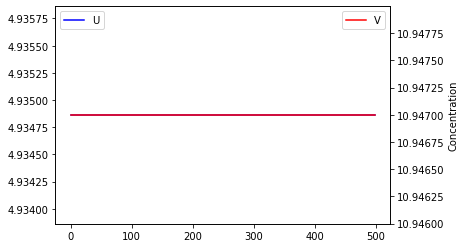

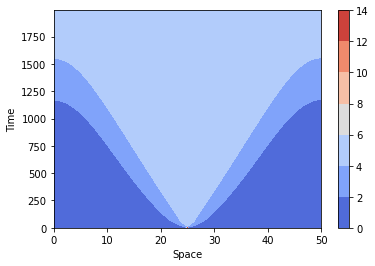

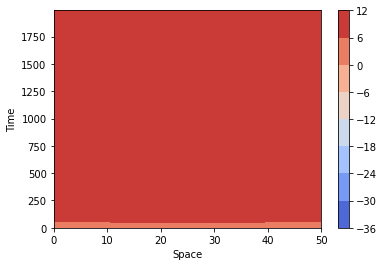

-----------------------------------------

539955.1
peaks:0


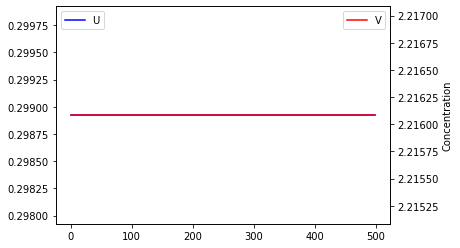

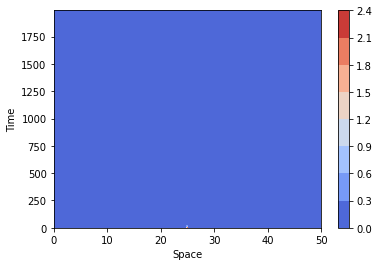

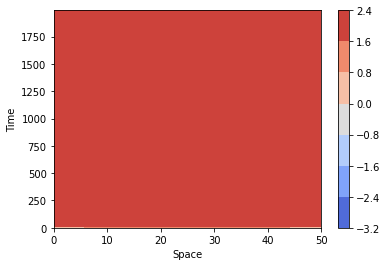

-----------------------------------------

356348.0
peaks:6


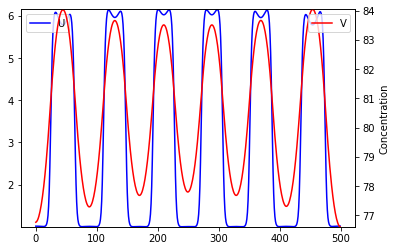

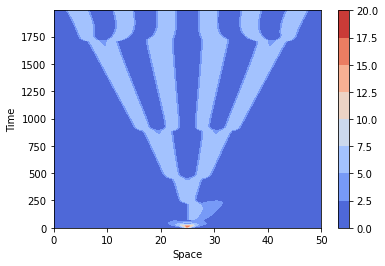

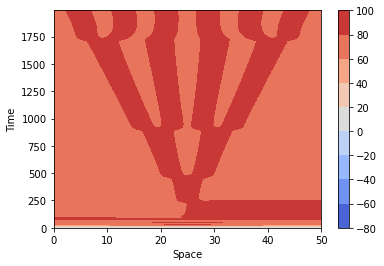

-----------------------------------------

1908473.0
peaks:12


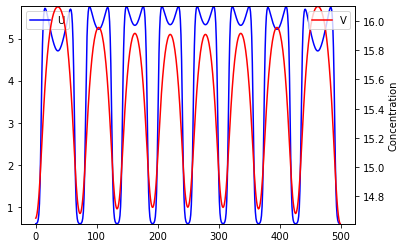

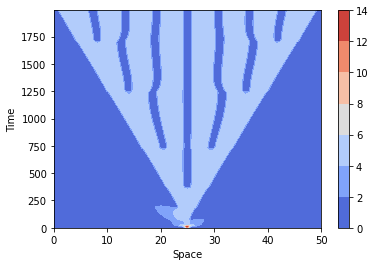

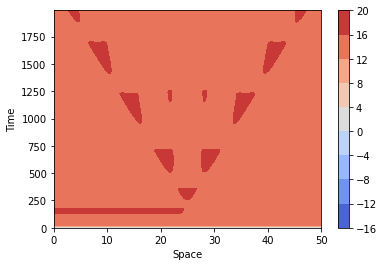

-----------------------------------------

1715773.1
peaks:0


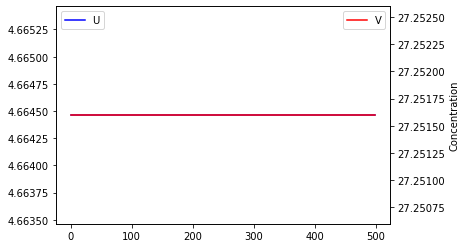

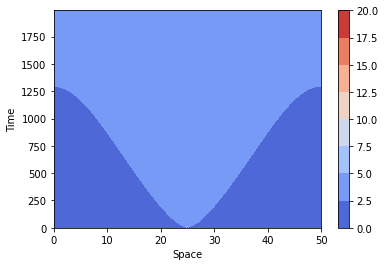

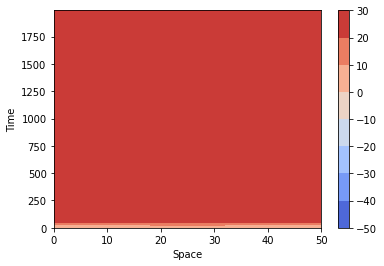

-----------------------------------------

1250091.0
peaks:12


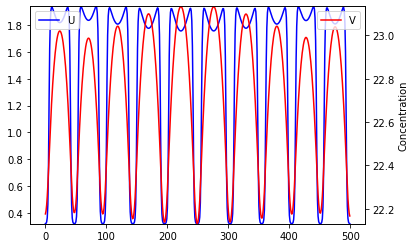

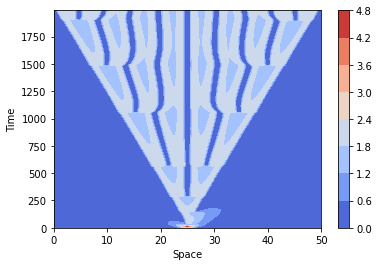

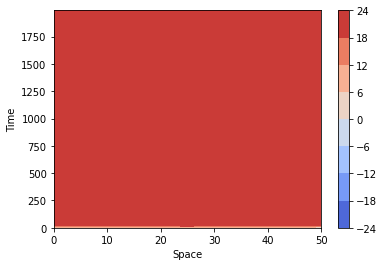

-----------------------------------------

1091272.0
peaks:9


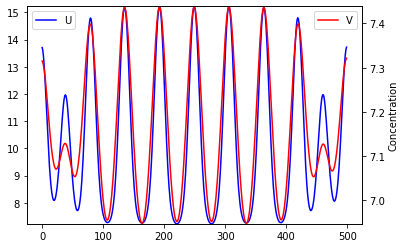

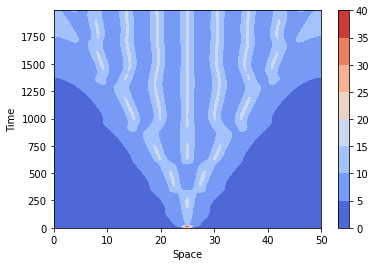

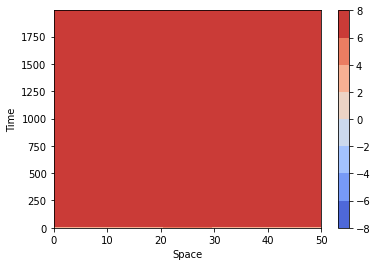

-----------------------------------------

184525.2
peaks:0


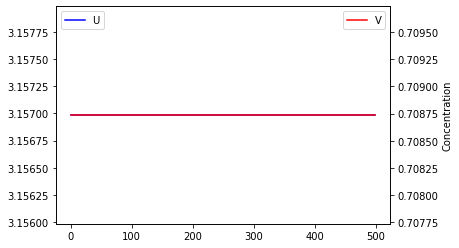

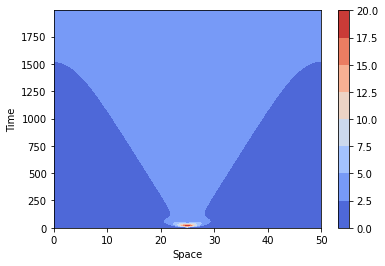

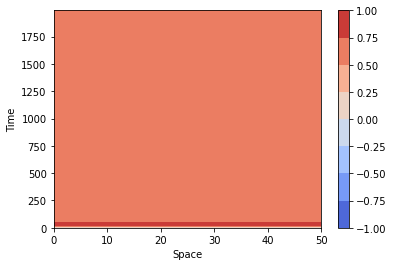

-----------------------------------------

990171.0
peaks:5


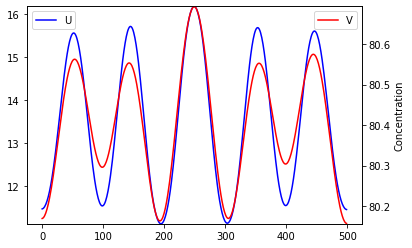

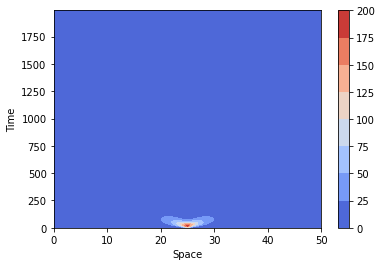

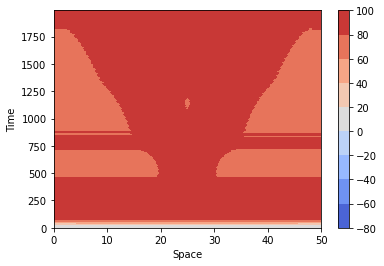

-----------------------------------------

1790718.0
peaks:3


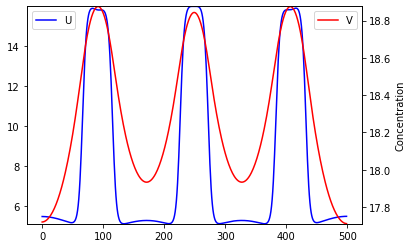

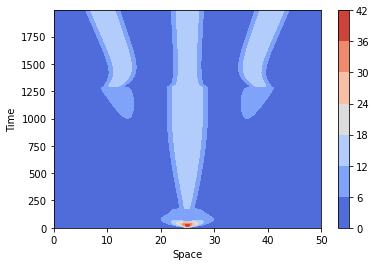

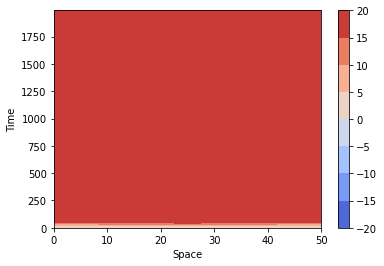

-----------------------------------------

826275.1
peaks:0


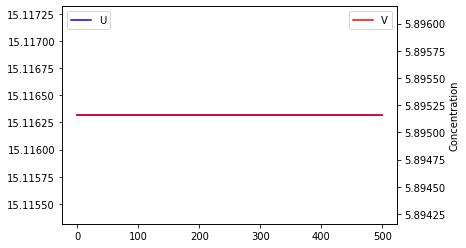

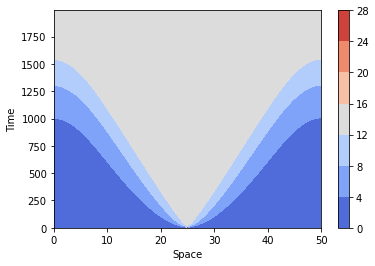

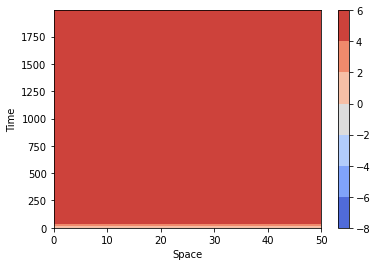

-----------------------------------------

1001840.0
peaks:3


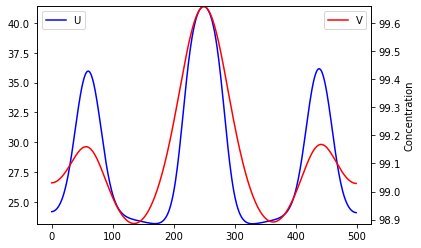

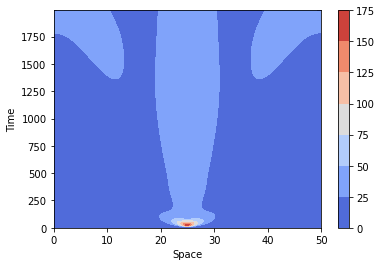

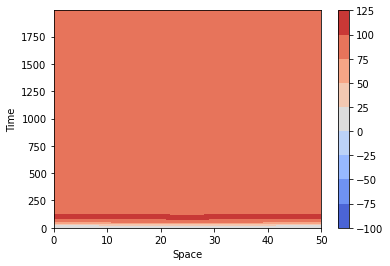

-----------------------------------------

995222.0
peaks:10


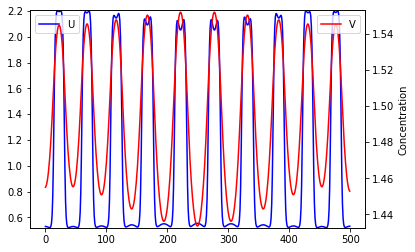

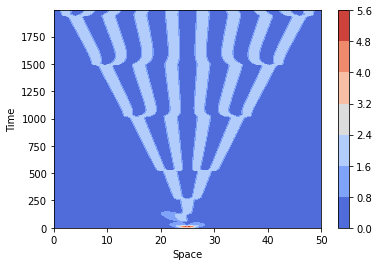

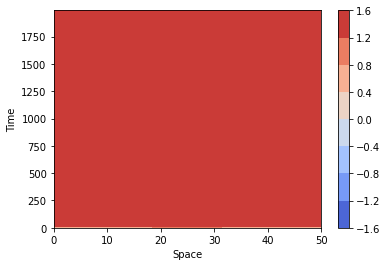

-----------------------------------------

258407.0
peaks:6


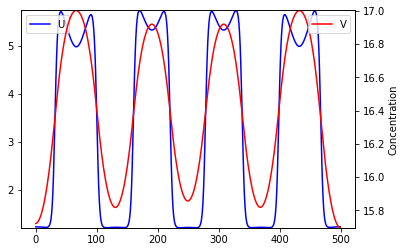

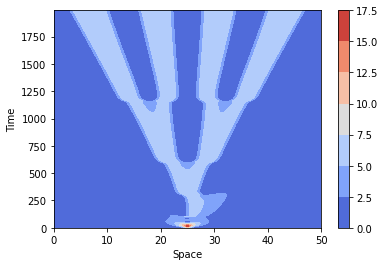

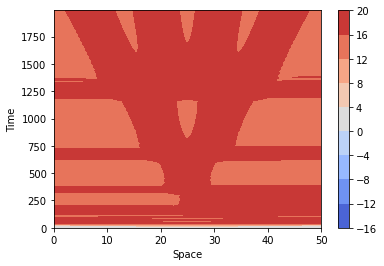

-----------------------------------------

1544038.0
peaks:6


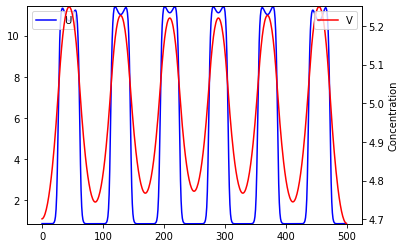

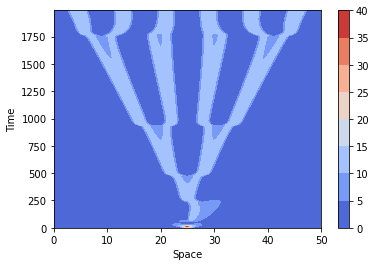

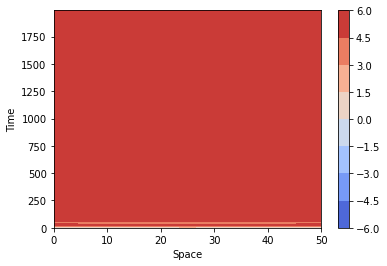

-----------------------------------------

1866454.0
peaks:6


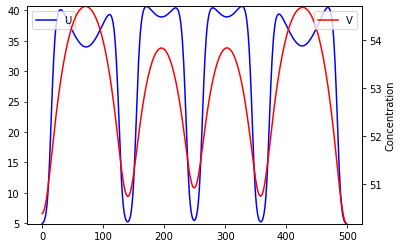

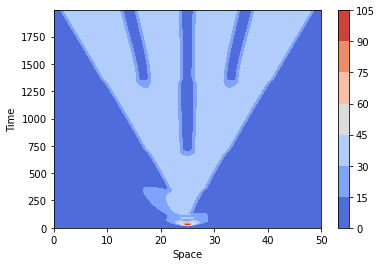

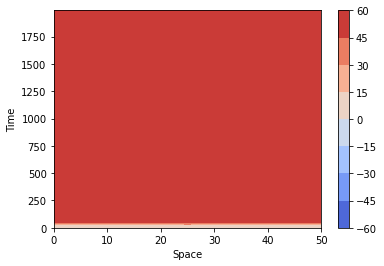

-----------------------------------------

84010.0
peaks:6


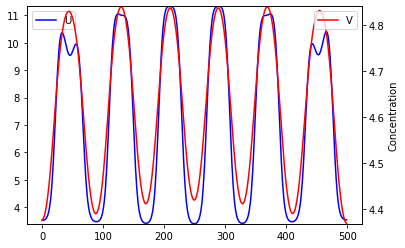

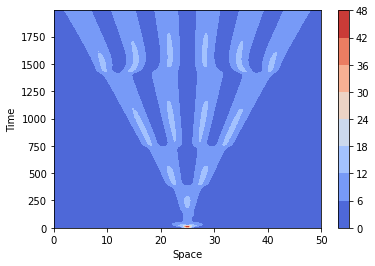

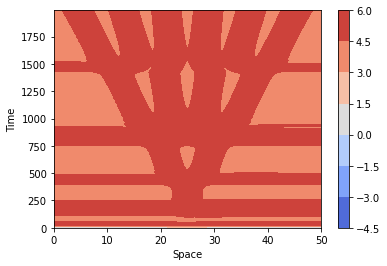

-----------------------------------------

1895355.0
peaks:12


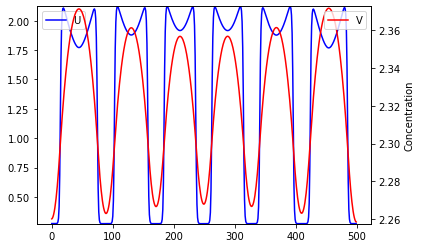

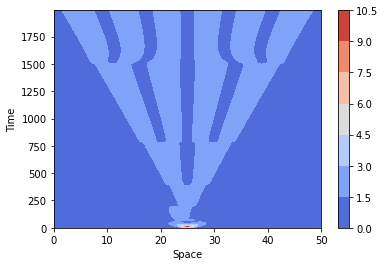

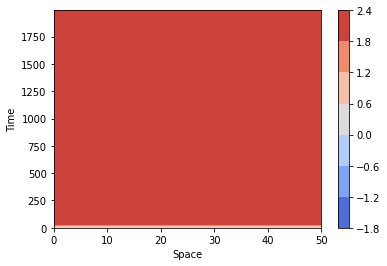

-----------------------------------------

463801.1
peaks:0


KeyboardInterrupt: 

In [42]:
mechanism = 'edgegrowth2'
folder = f'turinghill_variant{variant}'
filename= lambda mechanism, parID: 'circuit%s_variant%s_bc%s_%s_rate%s_ID%s_L%r_J%r_T%r_N%r'%(circuit_n,variant,boundaryCoeff, mechanism,rate,parID,L,J,T,N)
# parID_list = pickle.load( open(modellingpath + '/growth/out/numerical/%s/simulation/%s/parID_list_%s.pkl'%(mechanism,folder,filename(mechanism, 'x')), "rb"))
edgegrowth2_pattern_list = []
edgegrowth2_pattern_dict = {}

for parID in parID_list:
   print(parID)
   U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/simulation/%s/2Dfinal_%s.pkl'%(mechanism,folder,filename(mechanism, parID)), "rb"))
   U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/simulation/%s/2Drecord_%s.pkl'%(mechanism,folder,filename(mechanism, parID)), "rb"))
   pattern = patternClassification(U_final, U_record)
   edgegrowth2_pattern_list.append(pattern)
   edgegrowth2_pattern_dict[parID] = pattern
   plot1D(U_final, savefig=False,filename='')
   plt.show()
   surfpattern(U_record, [x_grid, reduced_t_grid], 'linear',morphogen=0, rate=0, savefig=False,filename='',logResults=False,normalize=False)
   plt.show()
   surfpattern(U_record, [x_grid, reduced_t_grid], 'linear',  morphogen=1, rate=0, savefig=False,filename='',logResults=False,normalize=False)
   plt.show()
   print('-----------------------------------------')
   print('')

In [12]:
count = pd.Series(edgegrowth2_pattern_list).value_counts()

count

no pattern          2
boundary pattern    1
dtype: int64

In [29]:
df = pd.DataFrame({'no growth': nogrowth_pattern_dict, 'edge growth': edgegrowth2_pattern_dict})
df

no growth           edge growth
104782.0   Stationary regular pattern  intermediate pattern
1748606.0                 Homogeneous            no pattern
1471198.2  Stationary regular pattern            no pattern
942691.1   Stationary regular pattern            no pattern
903128.0   Stationary regular pattern          weak pattern
1396843.0  Stationary regular pattern  intermediate pattern
1928281.0  Stationary regular pattern          weak pattern
195855.1   Stationary regular pattern            no pattern
1042553.0  Stationary regular pattern        strong pattern
1287827.0  Stationary regular pattern  intermediate pattern

In [32]:
import seaborn as sns
df_confusion_preReindexing = pd.crosstab( df['no growth'], df['edge growth'])

ax = sns.heatmap(df, linewidths=4,annot=True, cmap='Blues',cbar=True)


ValueError: could not convert string to float: 'Stationary regular pattern'

In [ ]:
df_confusion_preReindexing = pd.crosstab( df['balance'], df['system_class'], normalize='index')*100
ind = ['no pattern','boundary pattern','weak pattern','intermediate pattern','strong pattern']
cols = ['simple stable','simple unstable','no steady state','complex unstable','hopf', 'turing I hopf', 'turing I oscillatory', 'turing I']
df_confusion = df_confusion_preReindexing[cols]
# ind = ['Balanced','Semi balanced','Not balanced']
df_confusion = df_confusion_preReindexing.reindex(ind)

In [ ]:
    if n_peaks==0 or n_peaks==1:
        pattern = 'no pattern'
    if n_peaks ==2:
        pattern = 'boundary pattern'
    if n_peaks ==3:
        pattern = 'weak pattern'
    if n_peaks == 4:
        pattern = 'intermediate pattern'
    if n_peaks > 4:
        pattern  = 'strong pattern'